# 0.加载模块 Load module


In [1]:
# 导入所需的库
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import re
import time
import json
import subprocess
import requests
from requests.adapters import HTTPAdapter, Retry

import pubchempy as pcp
from pubchempy import PubChemHTTPError
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

import torch
from torch import nn
from torch.nn import functional as F
import transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
)
from torch.utils.data import Dataset, DataLoader

from d2l import torch as d2l
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
)

import sys
import seaborn as sns
# 设置调色板
# Set palette
sns.set_palette("muted")
# 设置环境变量为false
# Set the environment variable to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 导入模型文件
# Import model files
sys.path.append('.//code')
from model import Net, NetESM

In [2]:
# 定义关键词enzyme的原始数据文件
# Define the original file for keyword "enzyme"
DATE = "20240611"
path_source_enzyme = f"../data/data_reviewed_enzyme_{DATE}.tsv"
path_enzyme_tem = path_source_enzyme.replace(f'{DATE}', f'{DATE}_tem')
path_enzyme_SMILES = path_source_enzyme.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义额外的测试数据的原始数据文件
# Define the original files of additional test data
path_source_EC11 = f"../data/data_reviewed_EC11_{DATE}.tsv"
path_source_EC27 = f"../data/data_reviewed_EC27_{DATE}.tsv"
path_source_EC31 = f"../data/data_reviewed_EC31_{DATE}.tsv"
path_source_EC42 = f"../data/data_reviewed_EC42_{DATE}.tsv"
path_source_EC56 = f"../data/data_reviewed_EC56_{DATE}.tsv"
path_source_EC63 = f"../data/data_reviewed_EC63_{DATE}.tsv"
path_source_EC71 = f"../data/data_reviewed_EC71_{DATE}.tsv"
path_source_CA_unreviewed_5 = f'../data/data_unreviewed_CA_5_{DATE}.tsv'

# # 定义具有Catalytic Activity的原始数据文件，DATE后添加01，来区分源于path_source_enzyme的训练集、验证集和测试集文件
# # Define the original data file with Catalytic Activity, add '01' after DATE to distinguish the training set, validation set and test set files originating from path_source_enzyme
# DATE = "20240611"
# DATE += '01'
# path_source_CA = f"../data/data_reviewed_CA_{DATE}.tsv"
# path_CA_tem = path_source_CA.replace(f'{DATE}', f'{DATE}_tem')
# path_CA_SMILES = path_source_CA.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义提取的同一个催化反应的底物/产物的最大数量
# Define the maximum number of substrates/products extracted from the same catalytic reaction
NUMBER_REACTION = 10

# 定义序列聚类的一致性阈值，比如0.8,0.6,0.4
# Define the sequence identity threshold for sequence clustering, e.g., 0.8, 0.6, 0.4
SEQ_IDENTITY = 0.80
# 定义序列聚类的文件
# Define the sequence clustering files
path_infile_fasta = f"../data/review_sequence_{DATE}.fasta"
path_outfile_fasta = f"../data/review_sequence_{DATE}_cdhit_{int(SEQ_IDENTITY*100)}"
CLSTR_FILE = path_outfile_fasta + ".clstr"
path_train_fasta = f"../data/review_sequence_train_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"
path_test_fasta = f"../data/review_sequence_test_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"

# 定义训练集、验证集和测试集文件
# Define the files of training set, validation set, and testing set
path_train_data = f"../data/train_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_valid_data = f"../data/valid_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data = f"../data/test_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_80_100 = f"../data/test_data_80_100_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_60_80 = f"../data/test_data_60_80_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_40_60 = f"../data/test_data_40_60_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"

定义共用的函数 Define shared functions

In [3]:
# 初始化分子量缓存字典
# Initialize molecular weight cache dictionary
molecular_weight_cache = {}

def calculate_molecular_weight(smiles):
    """
    计算smiles分子的分子量
    Calculate the molecular weight
    """
    # 如果元素为空
    # If the element is empty
    if not smiles:
        return -1
    # 如果元素在字典中
    # If the element is in the dictionary
    elif smiles in molecular_weight_cache:
        mw = molecular_weight_cache[smiles]
    # 如果元素不在字典中
    # If the element is not in the dictionary
    else:
        mol = Chem.MolFromSmiles(smiles)
        try:
            mw = Descriptors.ExactMolWt(mol)
        except:
            try:
                # 使用pubchempy的get_compounds函数，根据SMILES字符串搜索PubChem Compound数据库，返回一个Compound对象的列表
                # Use pubchempy's get_compounds function to search the PubChem Compound database based on the SMILES string and return a list of Compound objects.
                compounds = pcp.get_compounds(smiles, "smiles")
                # 如果搜索成功，获取第一个Compound对象的分子量
                # If search success, get the molecular weight of the first Compound object
                mw = float(compounds[0].molecular_weight)
            # 如果搜索失败，将分子量设为0
            # If search fails, set the molecular weight to 0
            except:
                mw = 0
                print("error:", smiles)
        molecular_weight_cache[smiles] = mw
    return mw


def sort_smiles_by_mw(smiles_arr):
    '''
    将smiles_arr数组按照分子量由大到小排序
    Sort the smiles_arr array from large to small molecular weight
    '''
    mol_info = [(smiles, calculate_molecular_weight(smiles))
                for smiles in smiles_arr]
    mol_info.sort(key=lambda x: x[1], reverse=True)
    return np.array([x[0] for x in mol_info])

def load_json(path):
    ''' 
    从json文件中读取内容
    Read content from json file
    '''
    with open(path, "r") as file:
        name_to_smiles_cache = json.load(file)
    return name_to_smiles_cache

def save_json(dict,path):
    '''
    保存json文件
    Save json file
    '''
    with open(path, "w") as file:
        json.dump(dict, file)

def df_to_smiles(df, name_to_smiles_cache={}):
    '''
    将分子转化为SMILES字符串，并添加至原始dataframe
    Convert the molecule into SMILES strings and add it to the original dataframe
    '''
    df.replace(np.nan, "", inplace=True)
    substrate_product_smiles = [
        [handle_name_to_smiles(name, name_to_smiles_cache) for name in row]
        for row in df.iloc[:, 1:].values
    ]
    return (
        pd.merge(
            df,
            pd.DataFrame(substrate_product_smiles, columns=df.columns[1:]),
            left_index=True,
            right_index=True,
        ),
        name_to_smiles_cache,
    )

def handle_name_to_smiles(name, name_to_smiles_cache, retries=10):
    for _ in range(retries):
        try:
            return name_to_smiles(name, name_to_smiles_cache)
        except PubChemHTTPError as e:
            print(f"PubChemHTTPError: {e}, Retrying after 1 seconds...")
            time.sleep(1)
    return None


def name_to_smiles(name, name_to_smiles_cache, mode=0):
    '''
    将化学分子名称转化为SMILES字符串
    Convert chemical molecule names into SMILES strings
    '''
    smiles = None
    name = str(name).strip()
    if name in name_to_smiles_cache:
        return name_to_smiles_cache[name]
    elif name:
        results = pcp.get_compounds(name, "name")
        if results:
            smiles = results[0].canonical_smiles
            time.sleep(0.1)
            if mode == 1:
                smiles = results[0].isomeric_smiles
    name_to_smiles_cache[name] = smiles
    return smiles

def get_test_data(path, data, cols=['Sequence']):
    '''
    获取去重data相同列之后的测试数据
    Obtain test data after deduplicating the same columns of data
    '''
    # 读取数据集
    # Read the dataset
    if path.endswith(".csv"):
        test_data = pd.read_csv(path)
    elif path.endswith(".tsv"):
        test_data = pd.read_csv(path, sep="\t")
    elif path.endswith(".xlsx"):
        test_data = pd.read_excel(path)
    test_data.replace(np.nan, "", inplace=True)

    test_data = test_data[
        ~test_data[cols].apply(
            tuple, axis=1).isin(
                data[cols].apply(tuple, axis=1)
            )
    ]
    test_data.drop_duplicates(inplace=True)
    test_data.reset_index(inplace=True, drop=True)
    return test_data

# 4.模型训练 Model training


In [4]:
# 创建模型保存文件夹
# Create model saving folder
MODEL_FOLDER = "../model"

if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
    print(f"Created a new folder: {MODEL_FOLDER}")
else:
    print(f"{MODEL_FOLDER} folder existed")
    
# 定义常量
# Define constants
NUMBER_LABEL = 3
BATCH_SIZE = 16*1  # 批次大小 batch size
MAX_LEN_MOL = 256  # 底物分子序列最大长度 Maximum length of substrate molecule sequence
MAX_LEN_SEQ = 1573  # 氨基酸序列最大长度，序列长度的98%分位数 Maximum length of amino acid sequence, 98% percentile of sequence length

# 检查是否有可用的GPU，如果有，将设备设置为GPU，否则设置为CPU
# Check if there is an available GPU, if so, set the device to GPU, otherwise set to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 如果有多个GPU，选择其中一个进行训练, 比如0,1
# If there are multiple GPUs, choose one of them for training
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")

# 加载预训练的蛋白质语言模型和化学分子语言模型
# Load pre-trained protein language model and chemical molecule language model
prot_bert_tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")
prot_bert_model = AutoModel.from_pretrained("Rostlab/prot_bert")
ESM2_t33_tokenizer = AutoTokenizer.from_pretrained(
    "facebook/esm2_t33_650M_UR50D")
ESM2_t33_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
chemBERTa_MTR_tokenizer = AutoTokenizer.from_pretrained(
    "DeepChem/ChemBERTa-77M-MTR")
chemBERTa_MTR_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
chemBERTa_MLM_tokenizer = AutoTokenizer.from_pretrained(
    "DeepChem/ChemBERTa-77M-MLM")
chemBERTa_MLM_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")

../model folder existed


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 读取数据集
# Read the dataset
PATH_SMILES = path_enzyme_SMILES # 39k数据
# PATH_SMILES = path_CA_SMILES # 151k数据
data01 = pd.read_csv(PATH_SMILES, sep="\t")
data01.replace(np.nan, "", inplace=True)
data01

Sequence  \
0                                        AADIFAKFKTSMEVK   
1      AAVPSGASTGIYEALELRAVEHINKTIAPALVSKLAMQEFMILPVG...   
2      ADAADKPDDPNFFRMVEGFFDRGASIVEDKLVEDLRTKETPEQKKG...   
3      ADAADKPDDPNFFRMVEGFFDRGASIVEDKLVEDLRTKETPEQKKG...   
4                                   ADDINPKEECFFEDDYYEFE   
...                                                  ...   
39341  XXXXXXXXXXXDGHCIPALGFGTYKPIEVPKSKAMEAANLAIGVGY...   
39342  XXXXXXXXXXXDGHCIPALGFGTYKPIEVPKSKAMEAANLAIGVGY...   
39343  YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...   
39344  YIAGLLTGRPNSKAVGPSGVVLTAKQAFELANINSEFYELQPKEGL...   
39345  YLPAQQIDVQSSLLSDPSKVAGKTYDYIIAGGGLTGLTVAAKLTEN...   

        reaction1_substrate1_x reaction1_substrate2_x reaction1_substrate3_x  \
0                   coenzyme B      methyl-coenzyme M                          
1      (2R)-2-phosphoglycerate                                                 
2                          H2O            L-glutamate                 NAD(+)   
3                          H2O            L-glutamate                NADP(+)   
4                          H2O           L-isoleucine                     O2   
...                        ...                    ...                    ...   
39341                 morphine                 NAD(+)                          
39342                 morphine                NADP(+)                          
39343                      ATP                 Ca(2+)                    H2O   
39344          L-phenylalanine                                                 
39345           beta-D-glucose                     O2                          

      reaction1_substrate4_x reaction1_substrate5_x reaction1_substrate6_x  \
0                                                                            
1                                                                            
2                                                                            
3                                                                            
4                                                                            
...                      ...                    ...                    ...   
39341                                                                        
39342                                                                        
39343                                                                        
39344                                                                        
39345                                                                        

      reaction1_substrate7_x reaction1_substrate8_x reaction1_substrate9_x  \
0                                                                            
1                                                                            
2                                                                            
3                                                                            
4                                                                            
...                      ...                    ...                    ...   
39341                                                                        
39342                                                                        
39343                                                                        
39344                                                                        
39345                                                                        

       ...                               reaction1_product1_y  \
0      ...  CC(C(C(=O)[O-])NC(=O)CCCCCCSSCCS(=O)(=O)[O-])O...   
1      ...                              C=C(C(=O)O)OP(=O)(O)O   
2      ...  C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...   
3      ...  C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...   
4      ...                                  CCC(C)C(=O)C(=O)O   
...    ...                                                ...   
39341  ...  C1C=CN(C=C1C(=O)N)C2C(C(C

In [6]:
# 显示数据统计报告
# Display data statistics report
import ydata_profiling
new_name = data01.iloc[:,1:1+20].rename(columns={x:x.replace('reaction1_','').replace('_x','') for x in data01.columns[1:1+20]})
report = ydata_profiling.ProfileReport(
    new_name.replace(r"^\s*$", np.nan, regex=True,
                           inplace=False)
)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# 读取训练集、验证集、测试集
# Read the training set, validation set, and test set
train_data = pd.read_csv(path_train_data, sep="\t")
valid_data = pd.read_csv(path_valid_data, sep="\t")
test_data = pd.read_csv(path_test_data, sep="\t")
test_data_80_100 = pd.read_csv(path_test_data_80_100, sep="\t")
test_data_60_80 = pd.read_csv(path_test_data_60_80, sep="\t")
test_data_40_60 = pd.read_csv(path_test_data_40_60, sep="\t")
test_data_0_40 = pd.read_csv(path_test_data_0_40, sep="\t")
train_data.replace(np.nan, "", inplace=True)
valid_data.replace(np.nan, "", inplace=True)
test_data.replace(np.nan, "", inplace=True)
test_data_80_100.replace(np.nan, "", inplace=True)
test_data_60_80.replace(np.nan, "", inplace=True)
test_data_40_60.replace(np.nan, "", inplace=True)
test_data_0_40.replace(np.nan, "", inplace=True)

print(train_data.shape, valid_data.shape, test_data.shape, test_data_80_100.shape, test_data_60_80.shape, test_data_40_60.shape, test_data_0_40.shape)

# 生成词汇表
# Generate vocabulary
product_smiles_tokens = d2l.tokenize(
    pd.concat(
        [
            data01.iloc[:, 1 + 3 * NUMBER_REACTION],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 1],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 2],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 3],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 4],
        ]
    ),
    token="word",
)
product_smiles_vocab = d2l.Vocab(
    product_smiles_tokens,
    min_freq=1,
    reserved_tokens=["<pad>", "<bos>", "<eos>", "<sep>"],
)
len(product_smiles_vocab), product_smiles_vocab.token_to_idx

(31470, 7) (3150, 7) (4726, 7) (562, 7) (1821, 7) (1192, 7) (1151, 7)


(3213,
 {'<bos>': 0,
  '<eos>': 1,
  '<pad>': 2,
  '<sep>': 3,
  '<unk>': 4,
  'C': 5,
  'C#C': 6,
  'C#N': 7,
  'C(#N)N': 8,
  'C(#N)SO': 9,
  'C(#N)[S-]': 10,
  'C(=C(C(=O)[O-])[O-])C(=O)O': 11,
  'C(=C(C=C(C(=O)O)O)C(=O)O)C(=O)O': 12,
  'C(=C(C=O)Cl)C=C(C(=O)O)N': 13,
  'C(=CC(=C(C(=O)O)N)C(=O)[O-])C=O': 14,
  'C(=CC(=O)C(=O)O)C=C[O-]': 15,
  'C(=CC(=O)C=CC(=O)O)C=C(C(=O)[O-])[O-]': 16,
  'C(=CC(=O)O)C=C(C(=O)[O-])N': 17,
  'C(=CC(=O)O)C=C(C(=O)[O-])[O-]': 18,
  'C(=CC(=O)[O-])C(=CC(=O)C(=O)[O-])N': 19,
  'C(=CC(=O)[O-])C(=CC(=O)[O-])C(=O)[O-]': 20,
  'C(=CC(=O)[O-])C(=CC(=O)[O-])Cl': 21,
  'C(=CC(=O)[O-])C(=O)NC=O': 22,
  'C(=CC(=O)[O-])C(=O)[O-]': 23,
  'C(=CC(=O)[O-])C=CC(=O)[O-]': 24,
  'C(=CC=O)C=C(C(=O)O)N': 25,
  'C(=N)(N)N': 26,
  'C(=N)C(=O)[O-]': 27,
  'C(=NO)(N)N': 28,
  'C(=O)(C(=O)[O-])NC(=O)N': 29,
  'C(=O)(C(=O)[O-])[O-]': 30,
  'C(=O)(N)N': 31,
  'C(=O)(N)NC(=O)NC(=O)O': 32,
  'C(=O)(N)NC(=O)[O-]': 33,
  'C(=O)(N)OP(=O)(O)O': 34,
  'C(=O)(NC(=O)[O-])NC(=O)[O-]': 35,


In [8]:
# 定义损失权重
# Define loss weight
weight_loss = (train_data.iloc[:, [4, 5, 6]] != "").sum() / train_data.iloc[
    :, 0
].count()

weight_loss /= weight_loss.sum()
weight_loss = torch.tensor(
    weight_loss.values, device=device, dtype=torch.float32)
weight_loss

tensor([0.3931, 0.3698, 0.2370], device='cuda:0')

In [9]:
# 定义MyDataset类
# Define MyDataset class
class MyDataset(Dataset):
    def __init__(
        self,
        data,
        product_smiles_vocab,
        prot_tokenizer,
        chemBERTa_tokenizer,
        max_seq_length,
        max_mol_length,
    ):
        self.data = data
        self.product_smiles_vocab = product_smiles_vocab
        self.prot_tokenizer = prot_tokenizer
        self.chemBERTa_tokenizer = chemBERTa_tokenizer
        self.max_seq_length = max_seq_length
        self.max_mol_length = max_mol_length

    def __getitem__(self, index):
        row = self.data.iloc[index]
        sequence = row["Sequence"]
        substrate1 = row["reaction1_substrate1_y"]
        substrate2 = row["reaction1_substrate2_y"]
        substrate3 = row["reaction1_substrate3_y"]
        product1 = row["reaction1_product1_y"]
        product1 = "<pad>" if re.match(r"^\s*$", product1) else product1
        product_id1 = self.product_smiles_vocab.token_to_idx[product1]
        product2 = row["reaction1_product2_y"]
        product2 = "<pad>" if re.match(r"^\s*$", product2) else product2
        product_id2 = self.product_smiles_vocab.token_to_idx[product2]
        product3 = row["reaction1_product3_y"]
        product3 = "<pad>" if re.match(r"^\s*$", product3) else product3
        product_id3 = self.product_smiles_vocab.token_to_idx[product3]

        # 对酶序列进行编码，得到prot_model的输入向量
        # Encode the enzyme sequence to get the input vector of prot_model
        # 在序列中插入空格并替换非标准氨基酸
        # Insert spaces and replace non-standard amino acids in the sequence
        sequences = [
            " ".join(re.sub(r"[UZOB]", "X", sequence)) for sequence in [sequence]
        ]
        # 对序列进行分词和编码
        # Segment and encode sequences
        sequence_tokens = self.prot_tokenizer.batch_encode_plus(
            sequences,
            add_special_tokens=True,
            padding="max_length",
            return_tensors="pt",
            max_length=self.max_seq_length,
            truncation=True,
        )
        # 获取编码向量
        # Get encoding vector
        sequence_input_ids = sequence_tokens["input_ids"].clone().detach()
        sequence_attention_mask = sequence_tokens["attention_mask"].clone(
        ).detach()

        # 对催化底物进行编码，得到chemBERTa的输入向量
        # Encode the catalytic substrate to obtain the input vector of chemBERTa
        # 对SMILES字符串进行分词和编码
        # Segment and encode SMILES strings
        substrates = [
            sort_smiles_by_mw(np.array([substrate1, substrate2, substrate3]))
            for substrate1, substrate2, substrate3 in [
                (substrate1, substrate2, substrate3)
            ]
        ]
        substrates = [
            f"{substrate1}<sep>{substrate2}<sep>{substrate3}"
            for substrate1, substrate2, substrate3 in substrates
        ]

        substrate_tokens = self.chemBERTa_tokenizer.batch_encode_plus(
            substrates,
            add_special_tokens=True,
            padding="max_length",
            return_tensors="pt",
            max_length=self.max_mol_length,
            truncation=True,
        )
        # 获取编码向量
        # Get encoding vector
        substrate_input_ids = substrate_tokens["input_ids"].clone().detach()
        substrate_attention_mask = substrate_tokens["attention_mask"].clone(
        ).detach()

        return (
            sequence_input_ids,
            sequence_attention_mask,
            substrate_input_ids,
            substrate_attention_mask,
            product_id1,
            product_id2,
            product_id3,
        )

    def __len__(self):
        return len(self.data)


def test(data, model, criterion):
    '''
    模型测试函数
    Model testing function
    '''
    if isinstance(model, torch.nn.Module):
        model.eval()
    # 创建自定义的MyDataset实例
    # Create a custom MyDataset instance
    dataset = MyDataset(
        data=data,
        product_smiles_vocab=model.module.product_smiles_vocab,
        prot_tokenizer=model.module.prot_tokenizer,
        chemBERTa_tokenizer=model.module.chemBERTa_tokenizer,
        max_seq_length=model.module.max_seq_length,
        max_mol_length=model.module.max_mol_length,
    )

    # 创建DataLoader实例
    # Create DataLoader instance
    # dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=BATCH_SIZE,
        pin_memory=True,
    )
    # 初始化损失数组
    # Initialize the loss array
    loss_arr = torch.empty((0, NUMBER_LABEL), device=device)
    acc_arr = torch.empty((0, NUMBER_LABEL), device=device)

    # 遍历批次
    # Iterate through batches
    for (
        sequence_input_ids,
        sequence_attention_mask,
        substrate_input_ids,
        substrate_attention_mask,
        products1,
        products2,
        products3,
    ) in dataloader:
        # 如果序列为空，则跳过该批次
        # If the sequence is empty, skip the batch
        if sequence_input_ids is None:
            continue
        with torch.no_grad():
            (
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            ) = (
                sequence_input_ids.to(device),
                sequence_attention_mask.to(device),
                substrate_input_ids.to(device),
                substrate_attention_mask.to(device),
            )

            # 调用Net类的前向传播方法，得到预测的催化产物向量
            # Call the forward propagation method of Net class to obtain the predicted catalytic product vector
            predicted_vectors1, predicted_vectors2, predicted_vectors3 = model(
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            )

            # 对预测向量进行归一化，得到概率分布
            # Normalize the prediction vector to obtain the probability distribution
            predicted_probs1 = F.softmax(predicted_vectors1, dim=1)
            predicted_probs2 = F.softmax(predicted_vectors2, dim=1)
            predicted_probs3 = F.softmax(predicted_vectors3, dim=1)

            # 对概率分布进行取最大值，得到类别索引和概率值
            # Take the maximum value of the probability distribution and obtain the category index and probability value
            predicted_values1, predicted_ids1 = torch.max(
                predicted_probs1, dim=1)
            predicted_labels1 = predicted_ids1.cpu().detach().numpy().flatten()

            predicted_values2, predicted_ids2 = torch.max(
                predicted_probs2, dim=1)
            predicted_labels2 = predicted_ids2.cpu().detach().numpy().flatten()

            predicted_values3, predicted_ids3 = torch.max(
                predicted_probs3, dim=1)
            predicted_labels3 = predicted_ids3.cpu().detach().numpy().flatten()

            product_ids1 = products1.to(device)
            product_ids2 = products2.to(device)
            product_ids3 = products3.to(device)
            # 计算预测向量和真实向量之间的均方差损失
            # Calculate the mean square error loss between the predicted vector and the true vector
            loss1 = criterion(predicted_vectors1, product_ids1)
            loss2 = criterion(predicted_vectors2, product_ids2)
            loss3 = criterion(predicted_vectors3, product_ids3)
            loss_arr = torch.cat(
                (
                    loss_arr,
                    torch.tensor(
                        [[loss1.item(), loss2.item(), loss3.item()]], device=device
                    ),
                ),
                dim=0,
            )

            # 计算预测标签和真实标签之间的准确率
            # Calculate the accuracy between predicted labels and real labels
            product_ids1 = product_ids1.cpu().detach().numpy()
            acc1 = accuracy_score(product_ids1, predicted_labels1)

            product_ids2 = product_ids2.cpu().detach().numpy()
            acc2 = accuracy_score(product_ids2, predicted_labels2)

            product_ids3 = product_ids3.cpu().detach().numpy()
            acc3 = accuracy_score(product_ids3, predicted_labels3)


            acc_arr = torch.cat(
                (acc_arr, torch.tensor([[acc1, acc2, acc3]], device=device)), dim=0
            )

    # 手动清理GPU内存
    # Manually clear GPU memory
    torch.cuda.empty_cache()
    # 打印测试集的平均损失和评价指标
    # Print the average loss and evaluation index of the test set
    print(f"valid loss: {loss_arr.mean(dim=0)}")
    return (
        loss_arr.mean(dim=0),
        acc_arr.mean(dim=0),
    )

def train(data, test_data, model, criterion, path_savemodel, epochs=50, patience=10, lr=2e-5):
    '''
    模型训练函数
    Model training function
    '''
    start_epoch = 0
    best_test_loss = float("inf")
    best_epoch = 0
    # 定义优化器
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 如果存在检查点，则加载它
    # If a checkpoint exists, load it
    if os.path.isfile(path_savemodel):
        start_epoch, best_test_loss = load_checkpoint(model, optimizer, path_savemodel)
        best_epoch = start_epoch
    
    try:
        if isinstance(model, torch.nn.Module):
            model.train()
        # 创建自定义的MyDataset实例
        # Create a custom MyDataset instance
        dataset = MyDataset(
            data=data,
            product_smiles_vocab=model.module.product_smiles_vocab,
            prot_tokenizer=model.module.prot_tokenizer,
            chemBERTa_tokenizer=model.module.chemBERTa_tokenizer,
            max_seq_length=model.module.max_seq_length,
            max_mol_length=model.module.max_mol_length,
        )
        # 创建DataLoader实例
        # Create DataLoader instance
        # dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=BATCH_SIZE,
            pin_memory=True,
        )

        train_losses = torch.empty((0, NUMBER_LABEL), device=device)
        test_losses = torch.empty((0, NUMBER_LABEL), device=device)
        train_accs = torch.empty((0, NUMBER_LABEL), device=device)
        test_accs = torch.empty((0, NUMBER_LABEL), device=device)

        patience_counter = 0

        # 遍历epoch
        # Traverse epochs
        for epoch in range(start_epoch, epochs):
            # 初始化损失和评价指标
            # Initialize loss and evaluation indicators
            loss_arr = torch.empty((0, NUMBER_LABEL), device=device)
            acc_arr = torch.empty((0, NUMBER_LABEL), device=device)

            # 遍历批次
            # Iterate through batches
            for (
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
                products1,
                products2,
                products3,
            ) in dataloader:
                # 如果序列为空，跳过该批次
                # If the sequence is empty, skip the batch
                if sequence_input_ids is None:
                    continue
                (
                    sequence_input_ids,
                    sequence_attention_mask,
                    substrate_input_ids,
                    substrate_attention_mask,
                ) = (
                    sequence_input_ids.to(device),
                    sequence_attention_mask.to(device),
                    substrate_input_ids.to(device),
                    substrate_attention_mask.to(device),
                )

                # 调用Net类的前向传播方法，得到预测的催化产物向量
                # Call the forward propagation method of Net class to obtain the predicted catalytic product vector
                predicted_vectors1, predicted_vectors2, predicted_vectors3 = model(
                    sequence_input_ids,
                    sequence_attention_mask,
                    substrate_input_ids,
                    substrate_attention_mask,
                )

                product_ids1 = products1.to(device)
                product_ids2 = products2.to(device)
                product_ids3 = products3.to(device)
                # 计算预测向量和真实向量之间的均方差损失
                # Calculate the mean square error loss between the predicted vector and the true vector
                loss1 = criterion(predicted_vectors1, product_ids1)
                loss2 = criterion(predicted_vectors2, product_ids2)
                loss3 = criterion(predicted_vectors3, product_ids3)

                loss = (
                    weight_loss[0] * loss1 + weight_loss[1] *
                    loss2 + weight_loss[2] * loss3
                )

                loss_arr = torch.cat(
                    (
                        loss_arr,
                        torch.tensor(
                            [[loss1.item(), loss2.item(), loss3.item()]], device=device
                        ),
                    ),
                    dim=0,
                )
                with torch.no_grad():
                    # 对预测向量进行归一化，得到概率分布
                    # Normalize the prediction vector to obtain the probability distribution
                    predicted_probs1 = F.softmax(predicted_vectors1, dim=1)
                    predicted_probs2 = F.softmax(predicted_vectors2, dim=1)
                    predicted_probs3 = F.softmax(predicted_vectors3, dim=1)
                    # 对概率分布进行取最大值，得到类别索引和概率值
                    # Take the maximum value of the probability distribution and obtain the category index and probability value
                    predicted_values1, predicted_ids1 = torch.max(
                        predicted_probs1, dim=1)
                    predicted_labels1 = predicted_ids1.cpu().detach().numpy().flatten()

                    predicted_values2, predicted_ids2 = torch.max(
                        predicted_probs2, dim=1)
                    predicted_labels2 = predicted_ids2.cpu().detach().numpy().flatten()

                    predicted_values3, predicted_ids3 = torch.max(
                        predicted_probs3, dim=1)
                    predicted_labels3 = predicted_ids3.cpu().detach().numpy().flatten()

                    # 计算预测标签和真实标签之间的准确率
                    # Calculate the accuracy between predicted labels and true labels
                    product_ids1 = product_ids1.cpu().detach().numpy()
                    acc1 = accuracy_score(product_ids1, predicted_labels1)

                    product_ids2 = product_ids2.cpu().detach().numpy()
                    acc2 = accuracy_score(product_ids2, predicted_labels2)

                    product_ids3 = product_ids3.cpu().detach().numpy()
                    acc3 = accuracy_score(product_ids3, predicted_labels3)

                    acc_arr = torch.cat(
                        (acc_arr, torch.tensor([[acc1, acc2, acc3]], device=device)), dim=0
                    )

                # 反向传播梯度，并更新参数
                # Backpropagate gradients and update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 打印每个epoch的平均损失和评价指标
            # Print the average loss and evaluation indicators of each epoch
            print(f"Epoch {epoch+1}, train loss: {loss_arr.mean(dim=0)}")

            train_losses = torch.cat(
                (train_losses, loss_arr.mean(dim=0).unsqueeze(0)), dim=0
            )
            train_accs = torch.cat(
                (train_accs, acc_arr.mean(dim=0).unsqueeze(0)), dim=0)

            # 在测试集上进行测试，并获取平均损失和评价指标
            # Test on the test set and obtain the average loss and evaluation indicators
            test_loss, test_acc = test(test_data, model, criterion)
            test_losses = torch.cat((test_losses, test_loss.unsqueeze(0)), dim=0)
            test_accs = torch.cat((test_accs, test_acc.unsqueeze(0)), dim=0)
 
            # 早停策略
            # Early stopping strategy
            test_loss_epoch = weight_loss @ test_loss
            if test_loss_epoch < best_test_loss:
                best_test_loss = test_loss_epoch
                patience_counter = 0
                best_epoch = epoch+1

                # 仅保存最优损失的模型
                # Only save the model with the optimal loss
                save_checkpoint(model, optimizer, epoch, best_test_loss, path_savemodel)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"early stop at epoch {epoch+1}")
                    break
            # 手动清理GPU内存
            # Manually clear GPU memory
            torch.cuda.empty_cache()
            
        print(f'=> Training completed! Best loss at epoch {best_epoch}')
        return (train_losses, test_losses, train_accs, test_accs)
    except KeyboardInterrupt:
        # 打印中断位置，和模型保存位置
        # Print interruption location and model save location
        print(f"Training interrupted at epoch {epoch}. Best loss at epoch {best_epoch}.")
        raise

def save_checkpoint(model, optimizer, epoch, best_test_loss, path_savemodel):
    '''
    检查点保存函数
    Save checkpoint
    '''
    print("=> Saving checkpoint")
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'best_test_loss': best_test_loss
    }
    torch.save(state, path_savemodel)

def load_checkpoint(model, optimizer, path_savemodel):
    '''
    检查点加载函数
    Load checkpoint
    '''
    print("=> Loading checkpoint")
    checkpoint = torch.load(path_savemodel)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return (checkpoint['epoch'], checkpoint['best_test_loss'])

def mean_line(arr, step=5):
    arr = torch.tensor(arr, device=device)
    mean_arr = []
    for i in range(len(arr) - step):
        mean_arr.append(arr[i: i + step].mean(dim=0))
    # mean_arr转为torch张量
    return torch.tensor(mean_arr, device=device)


def draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=5, modelname="model01"
):
    '''
    绘制损失和评价指标的变化曲线
    Draw the change curve of loss and evaluation index
    '''
    # 创建图像目录figures
    # Create image directory figures
    if not os.path.exists('figures'):
        os.makedirs('figures')
    # 所有参数转为numpy数组
    # Convert all parameters to numpy arrays
    train_losses = train_losses.cpu().numpy()
    test_losses = test_losses.cpu().numpy()
    train_accs = train_accs.cpu().numpy()
    test_accs = test_accs.cpu().numpy()

    for i in range(train_losses.shape[1]):
        mean_train_losses = mean_line(
            train_losses[:, i], step=step).cpu().numpy()
        mean_test_losses = mean_line(
            test_losses[:, i], step=step).cpu().numpy()
        mean_train_accs = mean_line(train_accs[:, i], step=step).cpu().numpy()
        mean_test_accs = mean_line(test_accs[:, i], step=step).cpu().numpy()

        print(
            f"mean_train_loss_p{i+1}: {mean_train_losses[-1]}, mean_valid_loss_p{i+1}: {mean_test_losses[-1]}"
        )
        print(
            f"mean_train_acc_p{i+1}: {mean_train_accs[-1]}, mean_valid_acc_p{i+1}: {mean_test_accs[-1]}"
        )

        plt.figure(figsize=(10, 7))
        plt.title(f"{modelname}_{MODEL_FOLDER}_loss_p{i+1}")
        # torch张量转为numpy数组，便于绘图
        # Convert torch tensor to numpy array for easy drawing
        plt.plot(
            np.arange(1, len(train_losses) + 1),
            train_losses[:, i],
            label=f"train_loss_p{i+1}",
        )
        plt.plot(
            np.arange(1, len(test_losses) + 1),
            test_losses[:, i],
            label=f"valid_loss_p{i+1}",
        )
        plt.plot(
            np.arange(1 + step, len(mean_train_losses) + 1 + step),
            mean_train_losses,
            linestyle="--",
        )
        plt.plot(
            np.arange(1 + step, len(mean_test_losses) + 1 + step),
            mean_test_losses,
            linestyle="--",
        )
        plt.legend()
        plt.grid()
        # 保存图片
        # save picture
        plt.savefig(os.path.join('figures',f'{modelname}_loss_p_{i+1}.png'))
        plt.show()
        # plt.close()

        plt.figure(figsize=(10, 7))
        plt.title(f"{modelname}_{MODEL_FOLDER}_acc_p{i+1}")
        plt.plot(
            np.arange(1, len(train_accs) + 1),
            train_accs[:, i],
            label=f"train_acc_p{i+1}",
        )
        plt.plot(
            np.arange(1, len(test_accs) + 1), test_accs[:, i], label=f"valid_acc_p{i+1}"
        )
        plt.plot(
            np.arange(1 + step, len(mean_train_accs) + 1 + step),
            mean_train_accs,
            linestyle="--",
        )
        plt.plot(
            np.arange(1 + step, len(mean_test_accs) + 1 + step),
            mean_test_accs,
            linestyle="--",
        )
        plt.legend()
        plt.grid()
        # 保存图片
        # save picture
        plt.savefig(os.path.join('figures',f'{modelname}_acc_p_{i+1}.png'))
        plt.show()
        # plt.close()

In [8]:
path_savemodel = f"{MODEL_FOLDER}/model01_39k_{int(SEQ_IDENTITY*100)}.pth"
print("path_savemodel:", path_savemodel)

# 实例化Net类，传入蛋白语言模型和化学分子语言模型的模型和分词器
# Instantiate the Net class and pass in the model and word segmenter of protein language model and chemical molecule language model
model01 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
model01 = nn.DataParallel(model01, device_ids=[0, 1, 2, 3]).to(device)

# 定义一个交叉熵损失函数
# Define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# 调用训练函数，训练50个epoch
# Call the training function and train for 50 epochs
train_losses, test_losses, train_accs, test_accs = train(
    train_data, valid_data, model01, criterion, path_savemodel=path_savemodel, epochs=50, patience=10, lr=2e-5
)

path_savemodel: model/model01_39k_80.pth


[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not removing hydrogen atom without neighbors
[19:38:43] WARNING: not r

Epoch 1, train loss: tensor([5.1106, 4.5961, 1.9082], device='cuda:0')


[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not removing hydrogen atom without neighbors
[19:54:31] WARNING: not r

valid loss: tensor([3.9089, 3.7526, 1.0827], device='cuda:0')
=> Saving checkpoint


[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not removing hydrogen atom without neighbors
[19:55:59] WARNING: not r

Epoch 2, train loss: tensor([2.1753, 1.8147, 0.4860], device='cuda:0')


[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not removing hydrogen atom without neighbors
[20:11:46] WARNING: not r

valid loss: tensor([1.6798, 1.5065, 0.3400], device='cuda:0')
=> Saving checkpoint


[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not removing hydrogen atom without neighbors
[20:13:14] WARNING: not r

Epoch 3, train loss: tensor([1.2699, 1.0248, 0.2289], device='cuda:0')


[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not removing hydrogen atom without neighbors
[20:28:55] WARNING: not r

valid loss: tensor([1.3357, 1.2124, 0.2448], device='cuda:0')
=> Saving checkpoint


[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not removing hydrogen atom without neighbors
[20:30:22] WARNING: not r

Epoch 4, train loss: tensor([0.8941, 0.7186, 0.1511], device='cuda:0')


[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not removing hydrogen atom without neighbors
[20:46:00] WARNING: not r

valid loss: tensor([1.1587, 1.0542, 0.1995], device='cuda:0')
=> Saving checkpoint


[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not removing hydrogen atom without neighbors
[20:47:28] WARNING: not r

Epoch 5, train loss: tensor([0.6675, 0.5313, 0.1083], device='cuda:0')


[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not removing hydrogen atom without neighbors
[21:03:08] WARNING: not r

valid loss: tensor([1.0373, 0.9400, 0.1773], device='cuda:0')
=> Saving checkpoint


[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not removing hydrogen atom without neighbors
[21:04:35] WARNING: not r

Epoch 6, train loss: tensor([0.5133, 0.4064, 0.0814], device='cuda:0')


[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not removing hydrogen atom without neighbors
[21:20:16] WARNING: not r

valid loss: tensor([0.9417, 0.8620, 0.1681], device='cuda:0')
=> Saving checkpoint


[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not removing hydrogen atom without neighbors
[21:21:43] WARNING: not r

Epoch 7, train loss: tensor([0.4027, 0.3179, 0.0634], device='cuda:0')


[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not removing hydrogen atom without neighbors
[21:37:24] WARNING: not r

valid loss: tensor([0.8807, 0.8079, 0.1623], device='cuda:0')
=> Saving checkpoint


[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not removing hydrogen atom without neighbors
[21:38:52] WARNING: not r

Epoch 8, train loss: tensor([0.3209, 0.2519, 0.0499], device='cuda:0')


[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:32] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not removing hydrogen atom without neighbors
[21:54:33] WARNING: not r

valid loss: tensor([0.8277, 0.7590, 0.1515], device='cuda:0')
=> Saving checkpoint


[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not removing hydrogen atom without neighbors
[21:56:00] WARNING: not r

Epoch 9, train loss: tensor([0.2574, 0.2017, 0.0405], device='cuda:0')


[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not removing hydrogen atom without neighbors
[22:11:40] WARNING: not r

valid loss: tensor([0.7986, 0.7450, 0.1723], device='cuda:0')
=> Saving checkpoint


[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not removing hydrogen atom without neighbors
[22:13:08] WARNING: not r

Epoch 10, train loss: tensor([0.2077, 0.1614, 0.0325], device='cuda:0')


[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not removing hydrogen atom without neighbors
[22:28:49] WARNING: not r

valid loss: tensor([0.7692, 0.7078, 0.1508], device='cuda:0')
=> Saving checkpoint


[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not removing hydrogen atom without neighbors
[22:30:16] WARNING: not r

Epoch 11, train loss: tensor([0.1678, 0.1299, 0.0280], device='cuda:0')


[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not removing hydrogen atom without neighbors
[22:45:52] WARNING: not r

valid loss: tensor([0.7511, 0.6963, 0.1552], device='cuda:0')
=> Saving checkpoint


[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not removing hydrogen atom without neighbors
[22:47:19] WARNING: not r

Epoch 12, train loss: tensor([0.1368, 0.1056, 0.0245], device='cuda:0')


[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not removing hydrogen atom without neighbors
[23:02:57] WARNING: not r

valid loss: tensor([0.7425, 0.6836, 0.1534], device='cuda:0')
=> Saving checkpoint


[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not removing hydrogen atom without neighbors
[23:04:25] WARNING: not r

Epoch 13, train loss: tensor([0.1129, 0.0888, 0.0220], device='cuda:0')


[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not removing hydrogen atom without neighbors
[23:20:03] WARNING: not r

valid loss: tensor([0.7217, 0.6816, 0.1564], device='cuda:0')
=> Saving checkpoint


[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not removing hydrogen atom without neighbors
[23:21:30] WARNING: not r

Epoch 14, train loss: tensor([0.0943, 0.0746, 0.0215], device='cuda:0')


[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not removing hydrogen atom without neighbors
[23:37:00] WARNING: not r

valid loss: tensor([0.7148, 0.6642, 0.1567], device='cuda:0')
=> Saving checkpoint


[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not removing hydrogen atom without neighbors
[23:38:27] WARNING: not r

Epoch 15, train loss: tensor([0.0799, 0.0635, 0.0192], device='cuda:0')


[23:54:04] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not removing hydrogen atom without neighbors
[23:54:05] WARNING: not r

valid loss: tensor([0.7137, 0.6845, 0.1647], device='cuda:0')


[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not removing hydrogen atom without neighbors
[23:55:30] WARNING: not r

Epoch 16, train loss: tensor([0.0710, 0.0553, 0.0173], device='cuda:0')


[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not removing hydrogen atom without neighbors
[00:11:12] WARNING: not r

valid loss: tensor([0.7181, 0.6623, 0.1617], device='cuda:0')


[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not removing hydrogen atom without neighbors
[00:12:36] WARNING: not r

Epoch 17, train loss: tensor([0.0616, 0.0497, 0.0174], device='cuda:0')


[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not removing hydrogen atom without neighbors
[00:28:17] WARNING: not r

valid loss: tensor([0.7090, 0.6559, 0.1648], device='cuda:0')
=> Saving checkpoint


[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not removing hydrogen atom without neighbors
[00:29:44] WARNING: not r

Epoch 18, train loss: tensor([0.0570, 0.0444, 0.0165], device='cuda:0')


[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not removing hydrogen atom without neighbors
[00:45:23] WARNING: not r

valid loss: tensor([0.7183, 0.6655, 0.1907], device='cuda:0')


[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not removing hydrogen atom without neighbors
[00:46:47] WARNING: not r

Epoch 19, train loss: tensor([0.0529, 0.0414, 0.0183], device='cuda:0')


[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not removing hydrogen atom without neighbors
[01:02:25] WARNING: not r

valid loss: tensor([0.7121, 0.6526, 0.1635], device='cuda:0')
=> Saving checkpoint


[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not removing hydrogen atom without neighbors
[01:03:52] WARNING: not r

Epoch 20, train loss: tensor([0.0486, 0.0387, 0.0165], device='cuda:0')


[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not removing hydrogen atom without neighbors
[01:19:26] WARNING: not r

valid loss: tensor([0.7205, 0.6592, 0.1619], device='cuda:0')


[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not removing hydrogen atom without neighbors
[01:20:50] WARNING: not r

Epoch 21, train loss: tensor([0.0439, 0.0330, 0.0135], device='cuda:0')


[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not removing hydrogen atom without neighbors
[01:36:26] WARNING: not r

valid loss: tensor([0.7530, 0.6804, 0.1943], device='cuda:0')


[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not removing hydrogen atom without neighbors
[01:37:50] WARNING: not r

Epoch 22, train loss: tensor([0.0408, 0.0358, 0.0149], device='cuda:0')


[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not removing hydrogen atom without neighbors
[01:53:28] WARNING: not r

valid loss: tensor([0.7196, 0.6537, 0.1629], device='cuda:0')


[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not removing hydrogen atom without neighbors
[01:54:52] WARNING: not r

Epoch 23, train loss: tensor([0.0400, 0.0316, 0.0144], device='cuda:0')


[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not removing hydrogen atom without neighbors
[02:10:28] WARNING: not r

valid loss: tensor([0.7197, 0.6816, 0.1746], device='cuda:0')


[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not removing hydrogen atom without neighbors
[02:11:52] WARNING: not r

Epoch 24, train loss: tensor([0.0374, 0.0306, 0.0138], device='cuda:0')


[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not removing hydrogen atom without neighbors
[02:27:32] WARNING: not r

valid loss: tensor([0.7308, 0.6559, 0.1815], device='cuda:0')


[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not removing hydrogen atom without neighbors
[02:28:56] WARNING: not r

Epoch 25, train loss: tensor([0.0357, 0.0294, 0.0140], device='cuda:0')


[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not removing hydrogen atom without neighbors
[02:44:37] WARNING: not r

valid loss: tensor([0.7421, 0.6571, 0.1723], device='cuda:0')


[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not removing hydrogen atom without neighbors
[02:46:01] WARNING: not r

Epoch 26, train loss: tensor([0.0338, 0.0276, 0.0119], device='cuda:0')


[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not removing hydrogen atom without neighbors
[03:01:42] WARNING: not r

valid loss: tensor([0.7388, 0.7004, 0.1709], device='cuda:0')


[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not removing hydrogen atom without neighbors
[03:03:07] WARNING: not r

Epoch 27, train loss: tensor([0.0319, 0.0255, 0.0113], device='cuda:0')


[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not removing hydrogen atom without neighbors
[03:18:49] WARNING: not r

valid loss: tensor([0.7349, 0.6786, 0.1674], device='cuda:0')


[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not removing hydrogen atom without neighbors
[03:20:13] WARNING: not r

Epoch 28, train loss: tensor([0.0331, 0.0253, 0.0147], device='cuda:0')


[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:55] WARNING: not r

valid loss: tensor([0.7412, 0.6758, 0.1644], device='cuda:0')


[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not removing hydrogen atom without neighbors
[03:37:19] WARNING: not r

Epoch 29, train loss: tensor([0.0298, 0.0233, 0.0144], device='cuda:0')


[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not removing hydrogen atom without neighbors
[03:53:05] WARNING: not r

valid loss: tensor([0.7622, 0.6866, 0.1653], device='cuda:0')
early stop at epoch 29
=> Training completed! Best loss at epoch 19


mean_train_loss_p1: 0.03292068466544151, mean_valid_loss_p1: 0.7382909059524536
mean_train_acc_p1: 0.9887682079945801, mean_valid_acc_p1: 0.919375


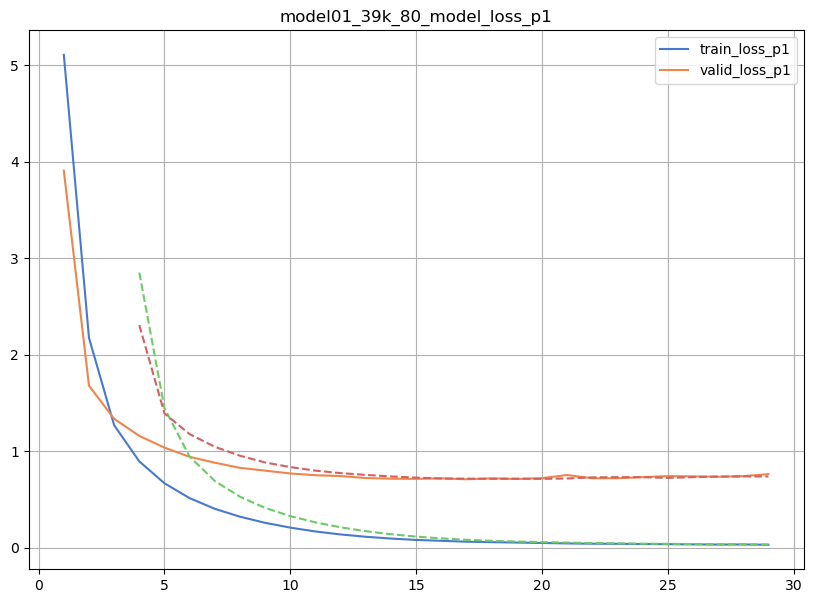

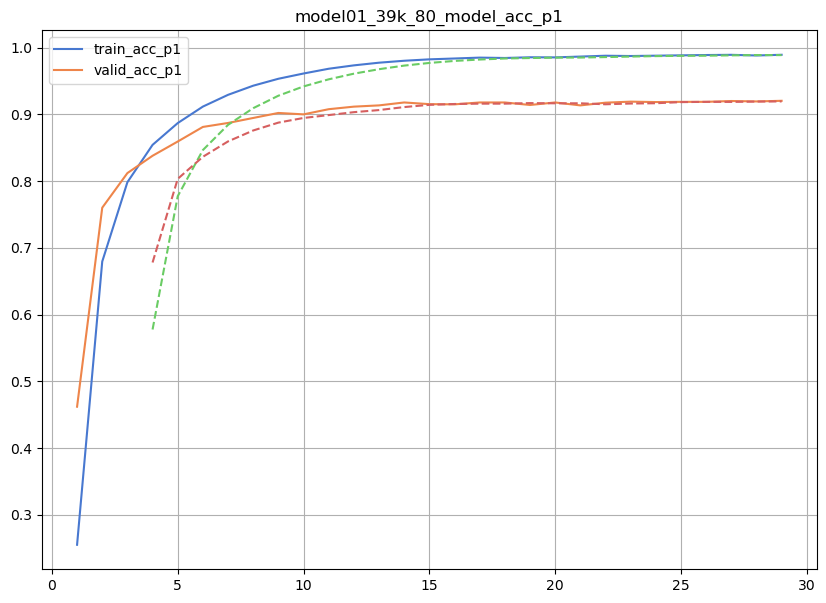

mean_train_loss_p2: 0.026127560064196587, mean_valid_loss_p2: 0.684951901435852
mean_train_acc_p2: 0.9909966932154788, mean_valid_acc_p2: 0.9123958333333333


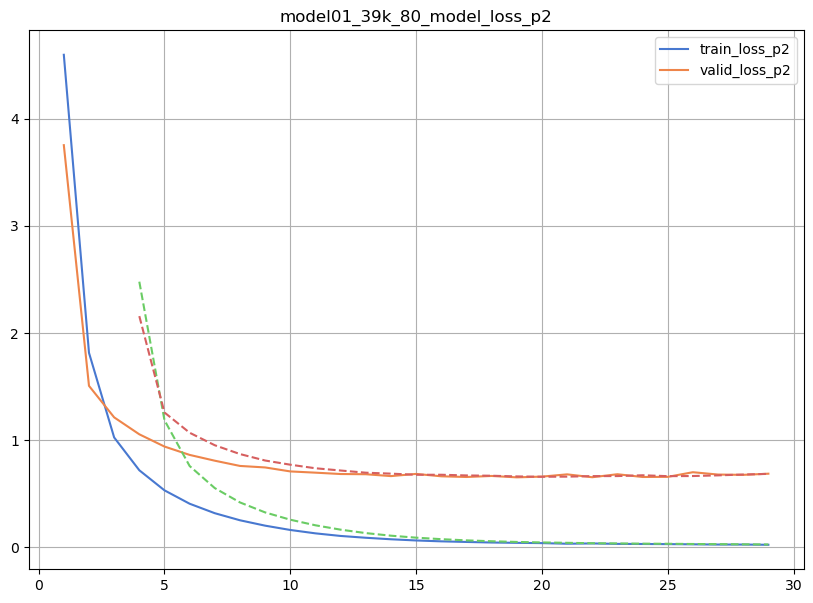

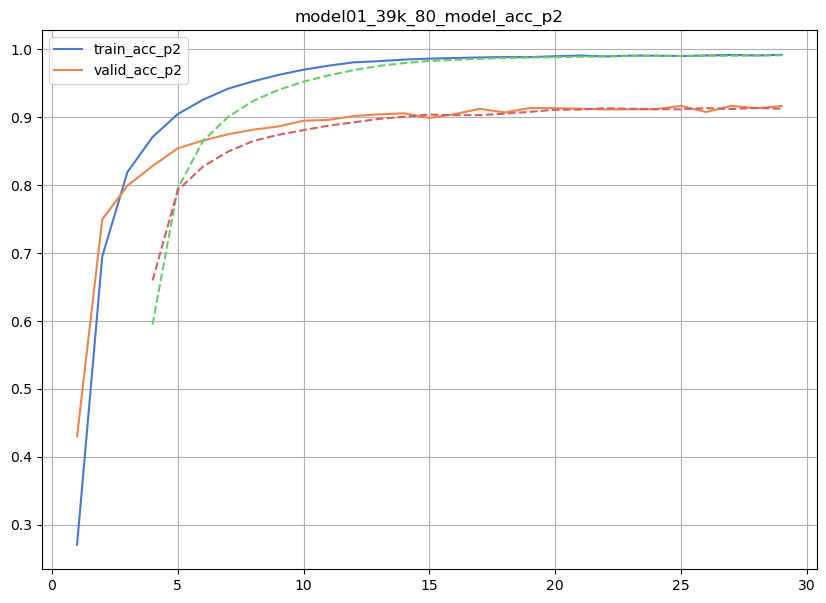

mean_train_loss_p3: 0.012630718760192394, mean_valid_loss_p3: 0.1675618588924408
mean_train_acc_p3: 0.9956968964675112, mean_valid_acc_p3: 0.9683333333333333


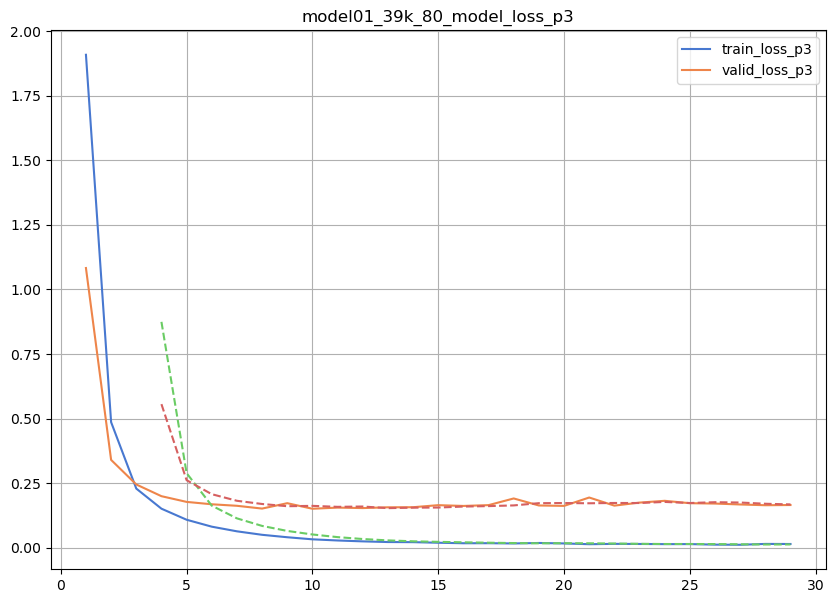

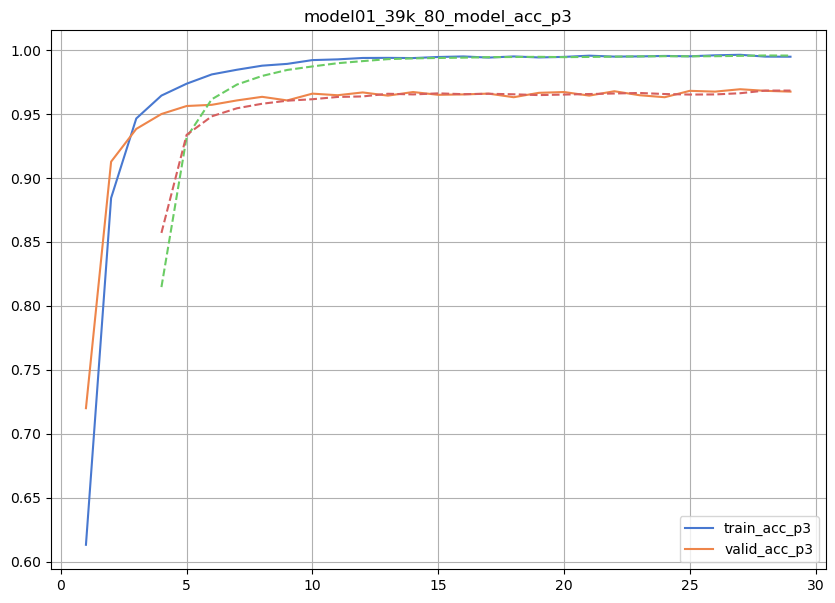

In [9]:
draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=3, modelname=f"model01_39k_{int(SEQ_IDENTITY*100)}"
)

In [10]:
path_savemodel = f"{MODEL_FOLDER}/model01_151k_{int(SEQ_IDENTITY*100)}.pth"
print("path_savemodel:", path_savemodel)

# 实例化Net类，传入蛋白语言模型和化学分子语言模型的模型和分词器
# Instantiate the Net class and pass in the model and word segmenter of protein language model and chemical molecule language model
model01 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
model01 = nn.DataParallel(model01, device_ids=[0, 1, 2, 3]).to(device)

# 定义一个交叉熵损失函数
# Define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# 调用训练函数，训练50个epoch
# Call the training function and train for 50 epochs
train_losses, test_losses, train_accs, test_accs = train(
    train_data, valid_data, model01, criterion, path_savemodel=path_savemodel, epochs=50, patience=10, lr=2e-5
)

path_savemodel: model/model01_151k_80.pth


[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not removing hydrogen atom without neighbors
[09:53:46] WARNING: not r

Epoch 1, train loss: tensor([3.8735, 3.5653, 1.1838], device='cuda:0')


[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not removing hydrogen atom without neighbors
[10:50:53] WARNING: not r

valid loss: tensor([2.6467, 2.6913, 0.8541], device='cuda:0')
=> Saving checkpoint


[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not removing hydrogen atom without neighbors
[10:56:01] WARNING: not r

Epoch 2, train loss: tensor([0.9457, 0.8122, 0.1943], device='cuda:0')


[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not removing hydrogen atom without neighbors
[11:53:09] WARNING: not r

valid loss: tensor([0.7239, 0.6590, 0.1362], device='cuda:0')
=> Saving checkpoint


[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not removing hydrogen atom without neighbors
[11:58:32] WARNING: not r

Epoch 3, train loss: tensor([0.3971, 0.3319, 0.0700], device='cuda:0')


[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not removing hydrogen atom without neighbors
[12:57:31] WARNING: not r

valid loss: tensor([0.5209, 0.4844, 0.1056], device='cuda:0')
=> Saving checkpoint


[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not removing hydrogen atom without neighbors
[13:02:53] WARNING: not r

Epoch 4, train loss: tensor([0.2305, 0.1934, 0.0427], device='cuda:0')


[14:01:57] WARNING: not removing hydrogen atom without neighbors
[14:01:57] WARNING: not removing hydrogen atom without neighbors
[14:01:57] WARNING: not removing hydrogen atom without neighbors
[14:01:57] WARNING: not removing hydrogen atom without neighbors
[14:01:57] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not removing hydrogen atom without neighbors
[14:01:58] WARNING: not r

valid loss: tensor([0.4379, 0.4149, 0.0910], device='cuda:0')
=> Saving checkpoint


[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not removing hydrogen atom without neighbors
[14:07:21] WARNING: not r

Epoch 5, train loss: tensor([0.1499, 0.1266, 0.0300], device='cuda:0')


[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not removing hydrogen atom without neighbors
[15:06:37] WARNING: not r

valid loss: tensor([0.3857, 0.3635, 0.0795], device='cuda:0')
=> Saving checkpoint


[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not removing hydrogen atom without neighbors
[15:11:59] WARNING: not r

Epoch 6, train loss: tensor([0.1043, 0.0887, 0.0235], device='cuda:0')


[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not removing hydrogen atom without neighbors
[16:11:22] WARNING: not r

valid loss: tensor([0.3629, 0.3401, 0.0868], device='cuda:0')
=> Saving checkpoint


[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not removing hydrogen atom without neighbors
[16:16:46] WARNING: not r

Epoch 7, train loss: tensor([0.0784, 0.0659, 0.0203], device='cuda:0')


[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not r

valid loss: tensor([0.3425, 0.3281, 0.0783], device='cuda:0')
=> Saving checkpoint


[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:11] WARNING: not r

Epoch 8, train loss: tensor([0.0610, 0.0515, 0.0184], device='cuda:0')


[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not removing hydrogen atom without neighbors
[18:22:50] WARNING: not r

valid loss: tensor([0.3411, 0.3286, 0.0860], device='cuda:0')


[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not removing hydrogen atom without neighbors
[18:28:17] WARNING: not r

Epoch 9, train loss: tensor([0.0490, 0.0408, 0.0161], device='cuda:0')


[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not removing hydrogen atom without neighbors
[19:28:58] WARNING: not r

valid loss: tensor([0.3423, 0.3243, 0.0800], device='cuda:0')
=> Saving checkpoint


[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not removing hydrogen atom without neighbors
[19:34:28] WARNING: not r

Epoch 10, train loss: tensor([0.0420, 0.0356, 0.0149], device='cuda:0')


[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not removing hydrogen atom without neighbors
[20:35:11] WARNING: not r

valid loss: tensor([0.3313, 0.3132, 0.0824], device='cuda:0')
=> Saving checkpoint


[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not removing hydrogen atom without neighbors
[20:40:42] WARNING: not r

Epoch 11, train loss: tensor([0.0380, 0.0324, 0.0152], device='cuda:0')


[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not removing hydrogen atom without neighbors
[21:41:30] WARNING: not r

valid loss: tensor([0.3382, 0.3241, 0.0798], device='cuda:0')


[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not removing hydrogen atom without neighbors
[21:46:56] WARNING: not r

Epoch 12, train loss: tensor([0.0334, 0.0261, 0.0127], device='cuda:0')


[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not removing hydrogen atom without neighbors
[22:47:42] WARNING: not r

valid loss: tensor([0.3378, 0.3441, 0.0818], device='cuda:0')


[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not removing hydrogen atom without neighbors
[22:53:10] WARNING: not r

Epoch 13, train loss: tensor([0.0309, 0.0257, 0.0123], device='cuda:0')


[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not removing hydrogen atom without neighbors
[23:53:56] WARNING: not r

valid loss: tensor([0.3449, 0.3375, 0.0767], device='cuda:0')


[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not removing hydrogen atom without neighbors
[23:59:23] WARNING: not r

Epoch 14, train loss: tensor([0.0290, 0.0235, 0.0128], device='cuda:0')


[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not removing hydrogen atom without neighbors
[00:59:49] WARNING: not r

valid loss: tensor([0.3487, 0.3297, 0.0868], device='cuda:0')


[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not removing hydrogen atom without neighbors
[01:05:16] WARNING: not r

Epoch 15, train loss: tensor([0.0267, 0.0212, 0.0104], device='cuda:0')


[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not removing hydrogen atom without neighbors
[02:05:55] WARNING: not r

valid loss: tensor([0.3484, 0.3267, 0.0792], device='cuda:0')


[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not removing hydrogen atom without neighbors
[02:11:23] WARNING: not r

Epoch 16, train loss: tensor([0.0277, 0.0215, 0.0116], device='cuda:0')


[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not removing hydrogen atom without neighbors
[03:12:05] WARNING: not r

valid loss: tensor([0.3594, 0.3324, 0.0790], device='cuda:0')


[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not removing hydrogen atom without neighbors
[03:17:31] WARNING: not r

Epoch 17, train loss: tensor([0.0242, 0.0201, 0.0101], device='cuda:0')


[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not removing hydrogen atom without neighbors
[04:18:17] WARNING: not r

valid loss: tensor([0.3534, 0.3401, 0.0822], device='cuda:0')


[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not removing hydrogen atom without neighbors
[04:23:45] WARNING: not r

Epoch 18, train loss: tensor([0.0241, 0.0193, 0.0098], device='cuda:0')


[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not removing hydrogen atom without neighbors
[05:24:22] WARNING: not r

valid loss: tensor([0.3601, 0.3390, 0.0925], device='cuda:0')


[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not removing hydrogen atom without neighbors
[05:29:50] WARNING: not r

Epoch 19, train loss: tensor([0.0233, 0.0184, 0.0103], device='cuda:0')


[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not removing hydrogen atom without neighbors
[06:30:33] WARNING: not r

valid loss: tensor([0.3574, 0.3370, 0.0926], device='cuda:0')


[06:36:01] WARNING: not removing hydrogen atom without neighbors
[06:36:01] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not removing hydrogen atom without neighbors
[06:36:02] WARNING: not r

Epoch 20, train loss: tensor([0.0233, 0.0186, 0.0100], device='cuda:0')


[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not r

valid loss: tensor([0.3558, 0.3448, 0.0826], device='cuda:0')
early stop at epoch 20
=> Training completed! Best loss at epoch 10


mean_train_loss_p1: 0.023883720859885216, mean_valid_loss_p1: 0.35697340965270996
mean_train_acc_p1: 0.991272297657082, mean_valid_acc_p1: 0.959484835600907


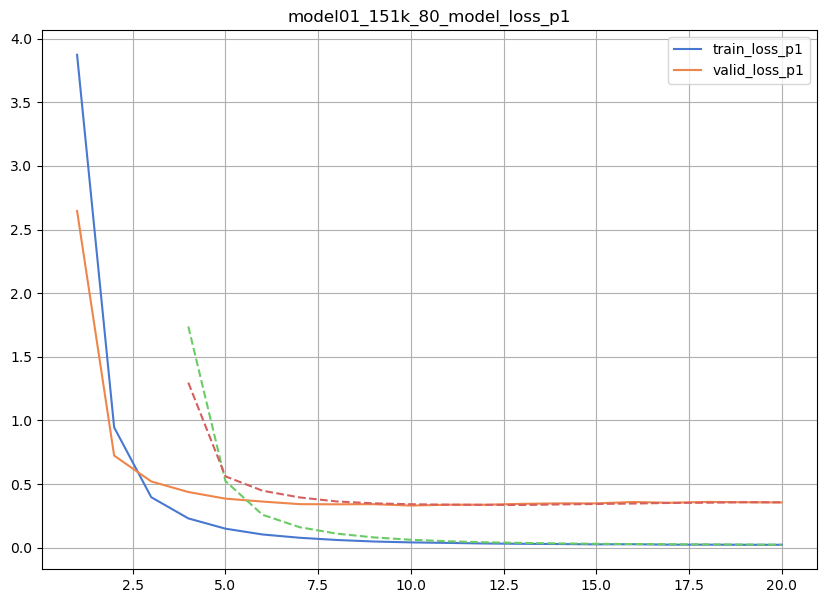

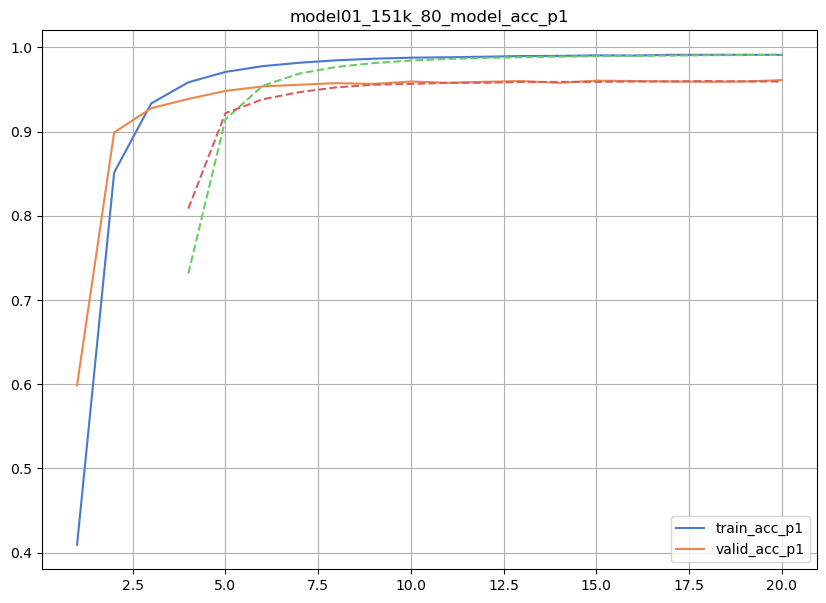

mean_train_loss_p2: 0.019258953630924225, mean_valid_loss_p2: 0.3387259840965271
mean_train_acc_p2: 0.9933633963436279, mean_valid_acc_p2: 0.9625584608843536


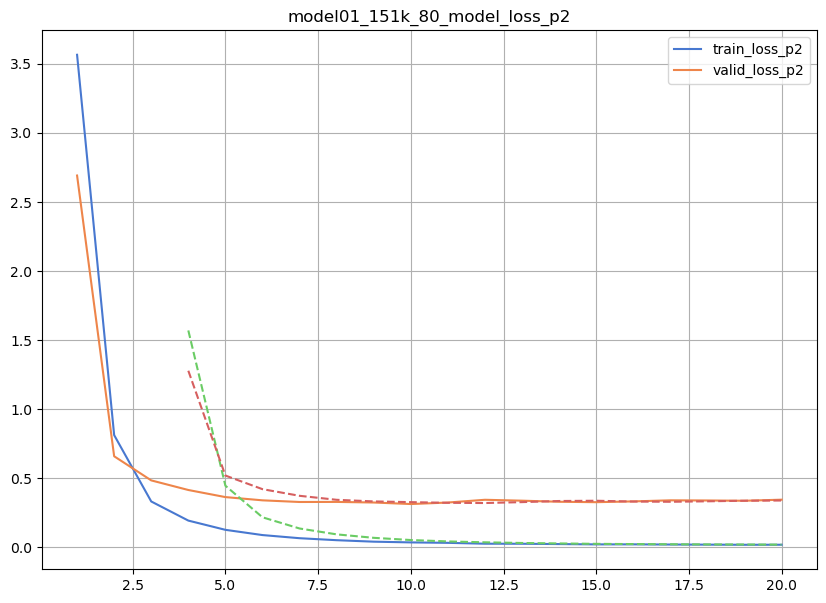

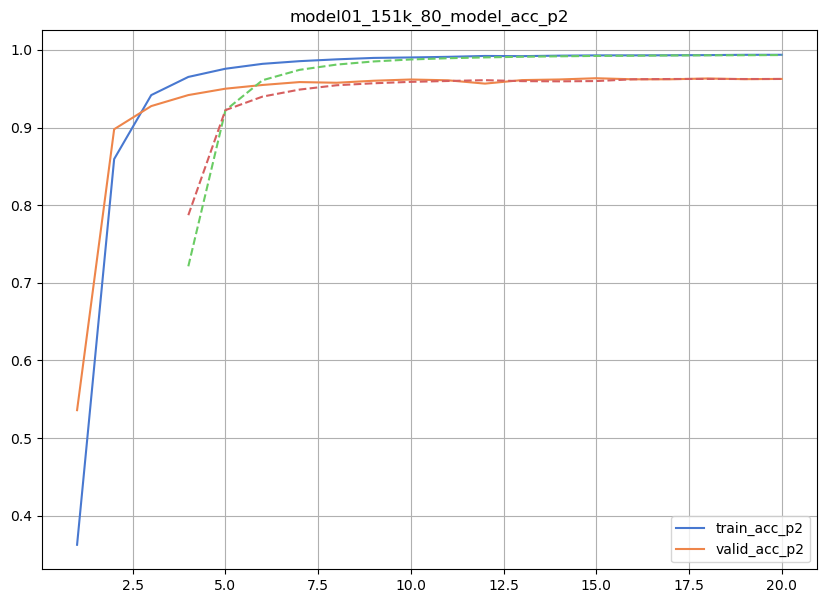

mean_train_loss_p3: 0.010040201246738434, mean_valid_loss_p3: 0.0891154408454895
mean_train_acc_p3: 0.9965860179268726, mean_valid_acc_p3: 0.9858630952380951


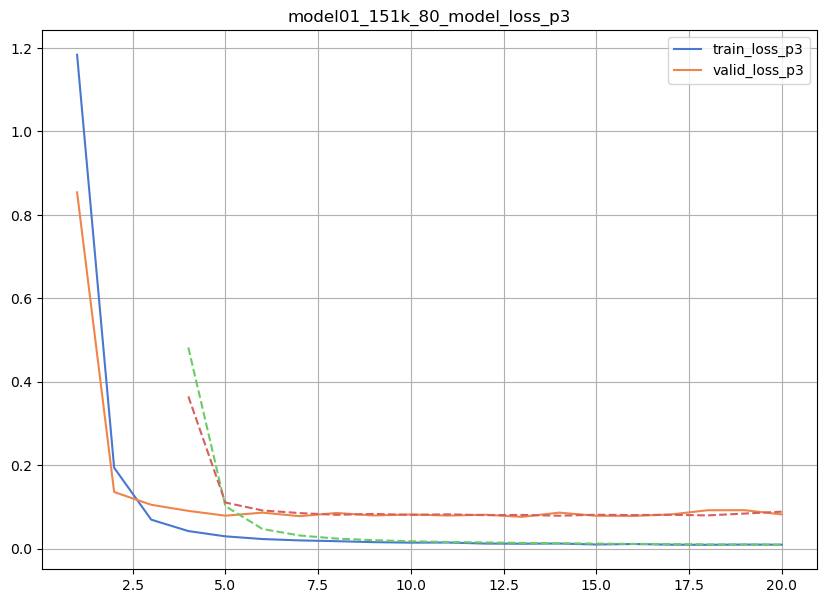

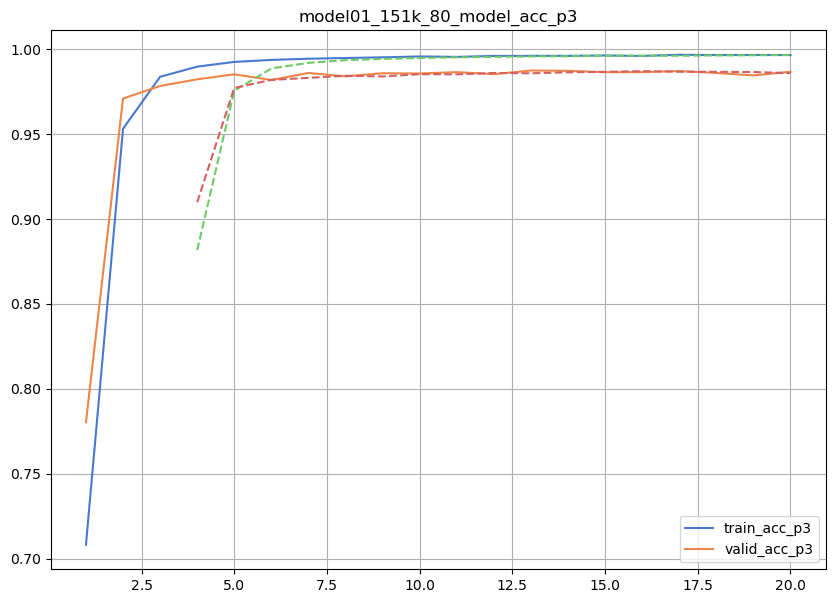

In [11]:
draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=3, modelname=f"model01_151k_{int(SEQ_IDENTITY*100)}"
)

In [9]:
path_savemodel = f"{MODEL_FOLDER}/model02_39k_{int(SEQ_IDENTITY*100)}.pth"
print("path_savemodel:", path_savemodel)

# 实例化Net类，传入蛋白语言模型和化学分子语言模型的模型和分词器
# Instantiate the Net class and pass in the model and word segmenter of protein language model and chemical molecule language model
model02 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MLM_model,
    chemBERTa_MLM_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
model02 = nn.DataParallel(model02, device_ids=[0, 1, 2, 3]).to(device)

# 定义一个交叉熵损失函数
# Define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# 调用训练函数，训练50个epoch
# Call the training function and train for 50 epochs
train_losses, test_losses, train_accs, test_accs = train(
    train_data, valid_data, model02, criterion, path_savemodel=path_savemodel, epochs=50, patience=10, lr=2e-5
)

path_savemodel: model/model02_39k_80.pth


[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not removing hydrogen atom without neighbors
[20:22:26] WARNING: not r

Epoch 1, train loss: tensor([5.4713, 4.8899, 1.9872], device='cuda:0')


[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not removing hydrogen atom without neighbors
[20:38:22] WARNING: not r

valid loss: tensor([4.3282, 4.0700, 1.2429], device='cuda:0')
=> Saving checkpoint


[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:50] WARNING: not r

Epoch 2, train loss: tensor([2.3555, 2.0616, 0.5473], device='cuda:0')


[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not removing hydrogen atom without neighbors
[20:55:45] WARNING: not r

valid loss: tensor([1.8463, 1.7410, 0.3707], device='cuda:0')
=> Saving checkpoint


[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not removing hydrogen atom without neighbors
[20:57:12] WARNING: not r

Epoch 3, train loss: tensor([1.4040, 1.1748, 0.2505], device='cuda:0')


[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not removing hydrogen atom without neighbors
[21:13:06] WARNING: not r

valid loss: tensor([1.4893, 1.4079, 0.2657], device='cuda:0')
=> Saving checkpoint


[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not removing hydrogen atom without neighbors
[21:14:34] WARNING: not r

Epoch 4, train loss: tensor([1.0048, 0.8365, 0.1600], device='cuda:0')


[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not removing hydrogen atom without neighbors
[21:30:19] WARNING: not r

valid loss: tensor([1.2859, 1.2347, 0.2168], device='cuda:0')
=> Saving checkpoint


[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not removing hydrogen atom without neighbors
[21:31:47] WARNING: not r

Epoch 5, train loss: tensor([0.7616, 0.6323, 0.1128], device='cuda:0')


[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not removing hydrogen atom without neighbors
[21:47:44] WARNING: not r

valid loss: tensor([1.1608, 1.1246, 0.1870], device='cuda:0')
=> Saving checkpoint


[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not removing hydrogen atom without neighbors
[21:49:12] WARNING: not r

Epoch 6, train loss: tensor([0.5916, 0.4906, 0.0834], device='cuda:0')


[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not removing hydrogen atom without neighbors
[22:05:11] WARNING: not r

valid loss: tensor([1.0802, 1.0322, 0.1704], device='cuda:0')
=> Saving checkpoint


[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not removing hydrogen atom without neighbors
[22:06:39] WARNING: not r

Epoch 7, train loss: tensor([0.4682, 0.3886, 0.0639], device='cuda:0')


[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not removing hydrogen atom without neighbors
[22:22:32] WARNING: not r

valid loss: tensor([1.0177, 0.9839, 0.1610], device='cuda:0')
=> Saving checkpoint


[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not removing hydrogen atom without neighbors
[22:24:00] WARNING: not r

Epoch 8, train loss: tensor([0.3752, 0.3110, 0.0507], device='cuda:0')


[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not removing hydrogen atom without neighbors
[22:39:55] WARNING: not r

valid loss: tensor([0.9750, 0.9421, 0.1583], device='cuda:0')
=> Saving checkpoint


[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not removing hydrogen atom without neighbors
[22:41:23] WARNING: not r

Epoch 9, train loss: tensor([0.3025, 0.2513, 0.0400], device='cuda:0')


[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not removing hydrogen atom without neighbors
[22:57:22] WARNING: not r

valid loss: tensor([0.9240, 0.9038, 0.1485], device='cuda:0')
=> Saving checkpoint


[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not removing hydrogen atom without neighbors
[22:58:50] WARNING: not r

Epoch 10, train loss: tensor([0.2464, 0.2043, 0.0332], device='cuda:0')


[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not removing hydrogen atom without neighbors
[23:14:48] WARNING: not r

valid loss: tensor([0.8872, 0.8701, 0.1549], device='cuda:0')
=> Saving checkpoint


[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not removing hydrogen atom without neighbors
[23:16:16] WARNING: not r

Epoch 11, train loss: tensor([0.2008, 0.1674, 0.0279], device='cuda:0')


[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not removing hydrogen atom without neighbors
[23:32:10] WARNING: not r

valid loss: tensor([0.8800, 0.8571, 0.1492], device='cuda:0')
=> Saving checkpoint


[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not removing hydrogen atom without neighbors
[23:33:38] WARNING: not r

Epoch 12, train loss: tensor([0.1650, 0.1385, 0.0242], device='cuda:0')


[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not removing hydrogen atom without neighbors
[23:49:29] WARNING: not r

valid loss: tensor([0.8656, 0.8447, 0.1559], device='cuda:0')
=> Saving checkpoint


[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not removing hydrogen atom without neighbors
[23:50:57] WARNING: not r

Epoch 13, train loss: tensor([0.1370, 0.1161, 0.0218], device='cuda:0')


[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not removing hydrogen atom without neighbors
[00:06:50] WARNING: not r

valid loss: tensor([0.8478, 0.8406, 0.1565], device='cuda:0')
=> Saving checkpoint


[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not removing hydrogen atom without neighbors
[00:08:18] WARNING: not r

Epoch 14, train loss: tensor([0.1161, 0.0990, 0.0200], device='cuda:0')


[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not removing hydrogen atom without neighbors
[00:24:14] WARNING: not r

valid loss: tensor([0.8441, 0.8330, 0.1505], device='cuda:0')
=> Saving checkpoint


[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not removing hydrogen atom without neighbors
[00:25:42] WARNING: not r

Epoch 15, train loss: tensor([0.1003, 0.0873, 0.0180], device='cuda:0')


[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not removing hydrogen atom without neighbors
[00:41:42] WARNING: not r

valid loss: tensor([0.8275, 0.8250, 0.1469], device='cuda:0')
=> Saving checkpoint


[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not removing hydrogen atom without neighbors
[00:43:10] WARNING: not r

Epoch 16, train loss: tensor([0.0871, 0.0759, 0.0166], device='cuda:0')


[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not removing hydrogen atom without neighbors
[00:59:04] WARNING: not r

valid loss: tensor([0.8082, 0.8146, 0.1430], device='cuda:0')
=> Saving checkpoint


[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not removing hydrogen atom without neighbors
[01:00:32] WARNING: not r

Epoch 17, train loss: tensor([0.0792, 0.0698, 0.0162], device='cuda:0')


[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not removing hydrogen atom without neighbors
[01:16:23] WARNING: not r

valid loss: tensor([0.8277, 0.8201, 0.1551], device='cuda:0')


[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not removing hydrogen atom without neighbors
[01:17:49] WARNING: not r

Epoch 18, train loss: tensor([0.0723, 0.0623, 0.0158], device='cuda:0')


[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not removing hydrogen atom without neighbors
[01:33:46] WARNING: not r

valid loss: tensor([0.8106, 0.7989, 0.1469], device='cuda:0')
=> Saving checkpoint


[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not removing hydrogen atom without neighbors
[01:35:14] WARNING: not r

Epoch 19, train loss: tensor([0.0661, 0.0577, 0.0151], device='cuda:0')


[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not removing hydrogen atom without neighbors
[01:51:07] WARNING: not r

valid loss: tensor([0.8239, 0.8049, 0.1564], device='cuda:0')


[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not removing hydrogen atom without neighbors
[01:52:32] WARNING: not r

Epoch 20, train loss: tensor([0.0606, 0.0532, 0.0151], device='cuda:0')


[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not r

valid loss: tensor([0.8076, 0.8049, 0.1696], device='cuda:0')


[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not removing hydrogen atom without neighbors
[02:09:48] WARNING: not r

Epoch 21, train loss: tensor([0.0562, 0.0486, 0.0129], device='cuda:0')


[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not removing hydrogen atom without neighbors
[02:25:41] WARNING: not r

valid loss: tensor([0.8091, 0.8233, 0.1633], device='cuda:0')


[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not removing hydrogen atom without neighbors
[02:27:06] WARNING: not r

Epoch 22, train loss: tensor([0.0524, 0.0467, 0.0139], device='cuda:0')


[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not removing hydrogen atom without neighbors
[02:43:06] WARNING: not r

valid loss: tensor([0.8029, 0.8097, 0.1561], device='cuda:0')


[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not removing hydrogen atom without neighbors
[02:44:30] WARNING: not r

Epoch 23, train loss: tensor([0.0490, 0.0434, 0.0126], device='cuda:0')


[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not removing hydrogen atom without neighbors
[03:00:23] WARNING: not r

valid loss: tensor([0.8021, 0.8181, 0.1723], device='cuda:0')


[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not removing hydrogen atom without neighbors
[03:01:48] WARNING: not r

Epoch 24, train loss: tensor([0.0464, 0.0406, 0.0114], device='cuda:0')


[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not removing hydrogen atom without neighbors
[03:17:40] WARNING: not r

valid loss: tensor([0.8054, 0.8055, 0.1535], device='cuda:0')


[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not removing hydrogen atom without neighbors
[03:19:05] WARNING: not r

Epoch 25, train loss: tensor([0.0451, 0.0397, 0.0125], device='cuda:0')


[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not removing hydrogen atom without neighbors
[03:34:56] WARNING: not r

valid loss: tensor([0.7903, 0.8000, 0.1476], device='cuda:0')
=> Saving checkpoint


[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not removing hydrogen atom without neighbors
[03:36:23] WARNING: not r

Epoch 26, train loss: tensor([0.0422, 0.0361, 0.0113], device='cuda:0')


[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not removing hydrogen atom without neighbors
[03:52:18] WARNING: not r

valid loss: tensor([0.8028, 0.8110, 0.1544], device='cuda:0')


[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not removing hydrogen atom without neighbors
[03:53:43] WARNING: not r

Epoch 27, train loss: tensor([0.0396, 0.0346, 0.0113], device='cuda:0')


[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not removing hydrogen atom without neighbors
[04:09:42] WARNING: not r

valid loss: tensor([0.7933, 0.8004, 0.1498], device='cuda:0')


[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not removing hydrogen atom without neighbors
[04:11:06] WARNING: not r

Epoch 28, train loss: tensor([0.0387, 0.0333, 0.0127], device='cuda:0')


[04:27:03] WARNING: not removing hydrogen atom without neighbors
[04:27:03] WARNING: not removing hydrogen atom without neighbors
[04:27:03] WARNING: not removing hydrogen atom without neighbors
[04:27:03] WARNING: not removing hydrogen atom without neighbors
[04:27:03] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not removing hydrogen atom without neighbors
[04:27:04] WARNING: not r

valid loss: tensor([0.8143, 0.8245, 0.1417], device='cuda:0')


[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not removing hydrogen atom without neighbors
[04:28:28] WARNING: not r

Epoch 29, train loss: tensor([0.0377, 0.0304, 0.0095], device='cuda:0')


[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not removing hydrogen atom without neighbors
[04:44:29] WARNING: not r

valid loss: tensor([0.8066, 0.8098, 0.1433], device='cuda:0')


[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not removing hydrogen atom without neighbors
[04:45:54] WARNING: not r

Epoch 30, train loss: tensor([0.0346, 0.0293, 0.0085], device='cuda:0')


[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not removing hydrogen atom without neighbors
[05:01:46] WARNING: not r

valid loss: tensor([0.8164, 0.8401, 0.1571], device='cuda:0')


[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not removing hydrogen atom without neighbors
[05:03:11] WARNING: not r

Epoch 31, train loss: tensor([0.0337, 0.0301, 0.0107], device='cuda:0')


[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not removing hydrogen atom without neighbors
[05:19:10] WARNING: not r

valid loss: tensor([0.8045, 0.8115, 0.1565], device='cuda:0')


[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not removing hydrogen atom without neighbors
[05:20:35] WARNING: not r

Epoch 32, train loss: tensor([0.0329, 0.0291, 0.0104], device='cuda:0')


[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not removing hydrogen atom without neighbors
[05:36:35] WARNING: not r

valid loss: tensor([0.8131, 0.8189, 0.1613], device='cuda:0')


[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not removing hydrogen atom without neighbors
[05:37:59] WARNING: not r

Epoch 33, train loss: tensor([0.0322, 0.0282, 0.0097], device='cuda:0')


[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not removing hydrogen atom without neighbors
[05:53:47] WARNING: not r

valid loss: tensor([0.8353, 0.8446, 0.1681], device='cuda:0')


[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not removing hydrogen atom without neighbors
[05:55:11] WARNING: not r

Epoch 34, train loss: tensor([0.0299, 0.0257, 0.0088], device='cuda:0')


[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not removing hydrogen atom without neighbors
[06:11:08] WARNING: not r

valid loss: tensor([0.8227, 0.8499, 0.1771], device='cuda:0')


[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not removing hydrogen atom without neighbors
[06:12:33] WARNING: not r

Epoch 35, train loss: tensor([0.0303, 0.0257, 0.0088], device='cuda:0')


[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not removing hydrogen atom without neighbors
[06:28:24] WARNING: not r

valid loss: tensor([0.8170, 0.8292, 0.1567], device='cuda:0')
early stop at epoch 35
=> Training completed! Best loss at epoch 25


mean_train_loss_p1: 0.03167204558849335, mean_valid_loss_p1: 0.8237055540084839
mean_train_acc_p1: 0.9877413617886179, mean_valid_acc_p1: 0.9034583333333335


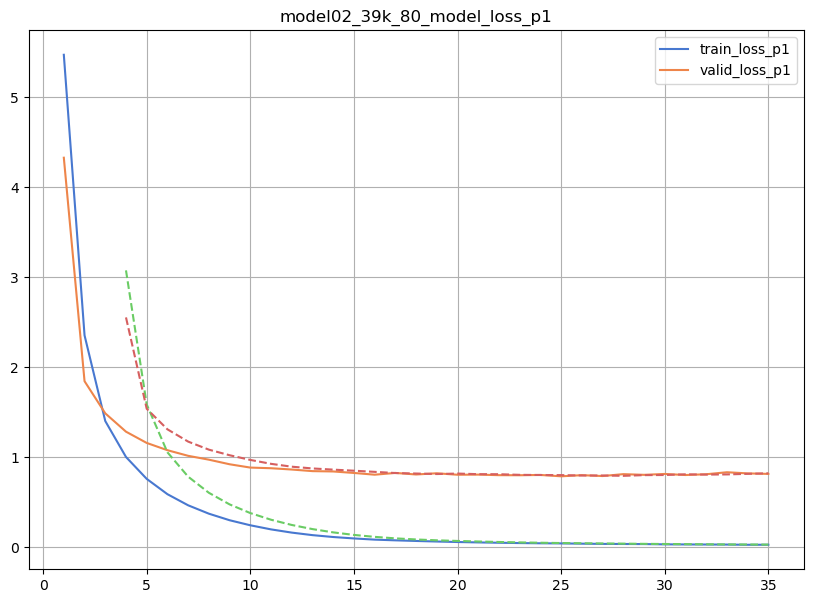

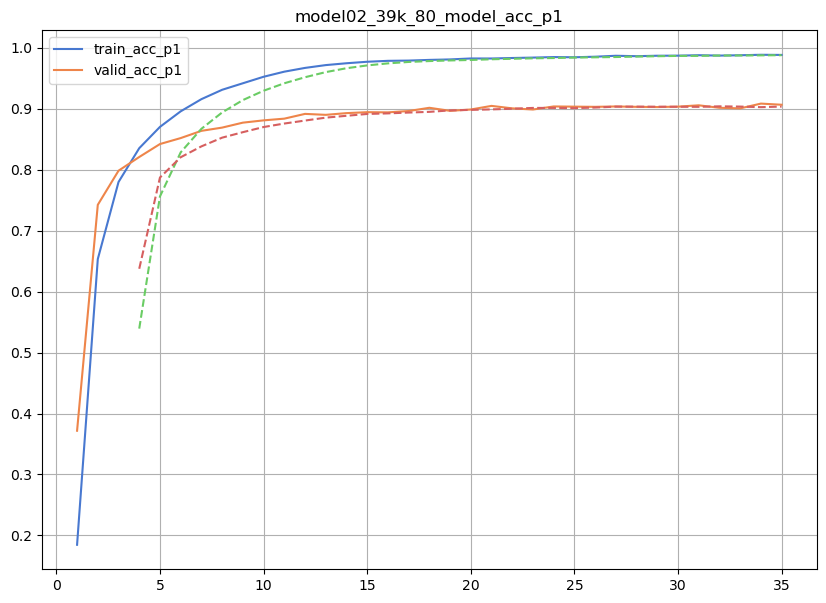

mean_train_loss_p2: 0.027684133499860764, mean_valid_loss_p2: 0.8378015756607056
mean_train_acc_p2: 0.9900491192411924, mean_valid_acc_p2: 0.8826527777777777


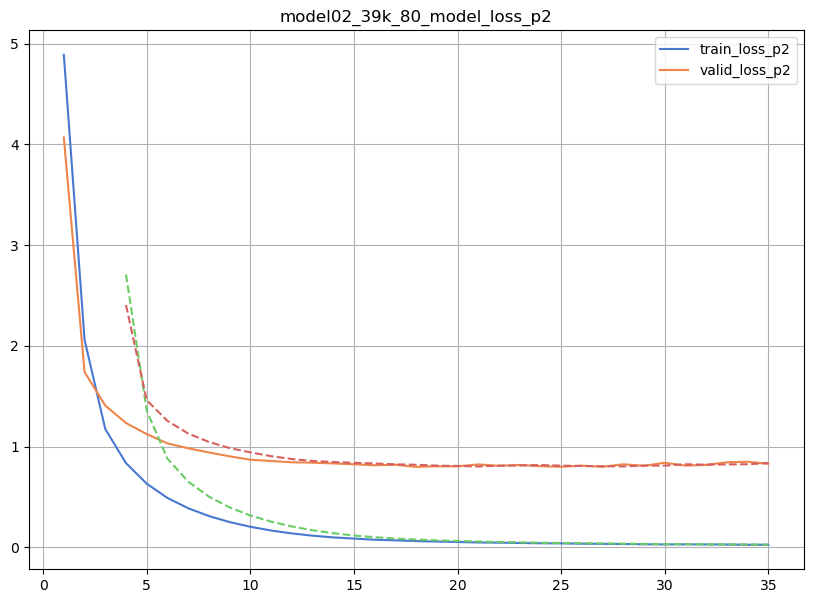

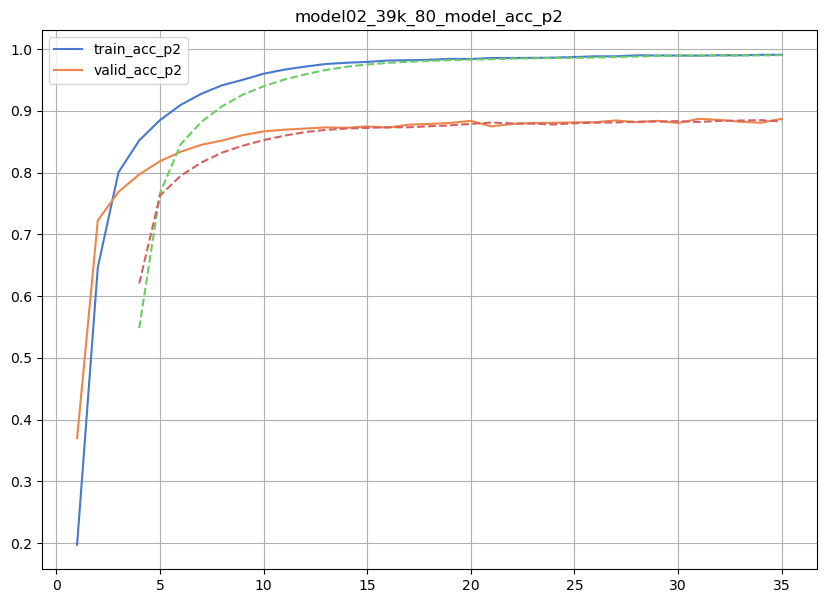

mean_train_loss_p3: 0.009644273668527603, mean_valid_loss_p3: 0.16885453462600708
mean_train_acc_p3: 0.9961890243902439, mean_valid_acc_p3: 0.9665625


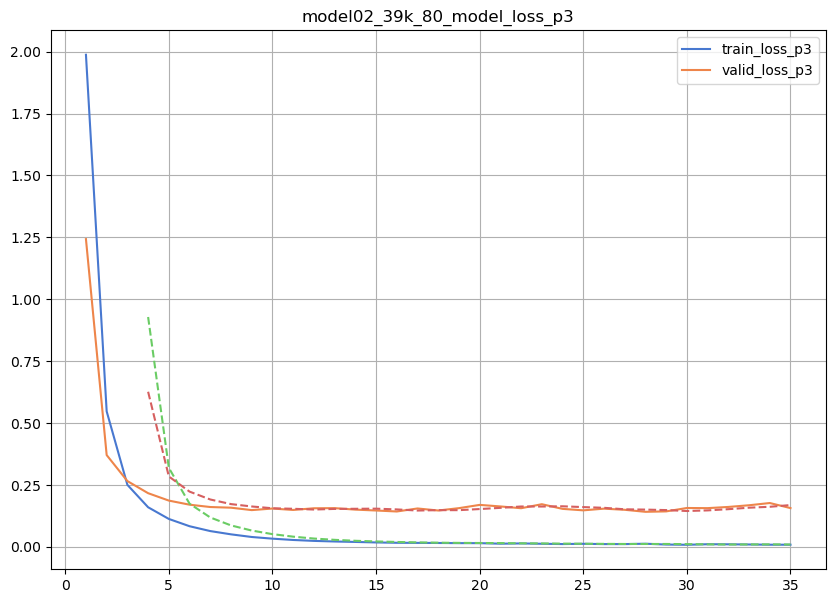

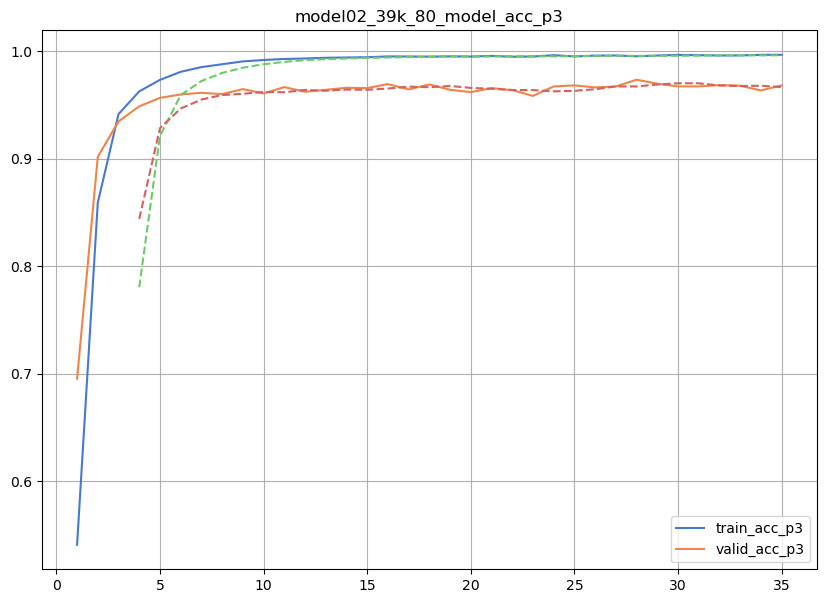

In [10]:
draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=3, modelname=f"model02_39k_{int(SEQ_IDENTITY*100)}"
)

In [9]:
path_savemodel = f"{MODEL_FOLDER}/model03_39k_{int(SEQ_IDENTITY*100)}.pth"
print("path_savemodel:", path_savemodel)

# 实例化Net类，传入蛋白语言模型和化学分子语言模型的模型和分词器
# Instantiate the Net class and pass in the model and word segmenter of protein language model and chemical molecule language model
model03 = NetESM(
    ESM2_t33_model,
    ESM2_t33_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
model03 = nn.DataParallel(model03, device_ids=[0, 1, 2, 3]).to(device)

# 定义一个交叉熵损失函数
# Define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# 调用训练函数，训练50个epoch
# Call the training function and train for 50 epochs
train_losses, test_losses, train_accs, test_accs = train(
    train_data, valid_data, model03, criterion, path_savemodel=path_savemodel, epochs=50, patience=10, lr=2e-5
)

path_savemodel: model/model03_39k_80.pth


[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not removing hydrogen atom without neighbors
[20:15:07] WARNING: not r

Epoch 1, train loss: tensor([4.8258, 4.3453, 1.7163], device='cuda:0')


[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not removing hydrogen atom without neighbors
[20:37:20] WARNING: not r

valid loss: tensor([3.7062, 3.5348, 0.9771], device='cuda:0')
=> Saving checkpoint


[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not removing hydrogen atom without neighbors
[20:39:23] WARNING: not r

Epoch 2, train loss: tensor([1.9730, 1.6066, 0.4030], device='cuda:0')


[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not removing hydrogen atom without neighbors
[21:02:07] WARNING: not r

valid loss: tensor([1.5677, 1.3854, 0.2794], device='cuda:0')
=> Saving checkpoint


[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not removing hydrogen atom without neighbors
[21:04:19] WARNING: not r

Epoch 3, train loss: tensor([1.1120, 0.8637, 0.1736], device='cuda:0')


[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not removing hydrogen atom without neighbors
[21:28:05] WARNING: not r

valid loss: tensor([1.2452, 1.0963, 0.2072], device='cuda:0')
=> Saving checkpoint


[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not removing hydrogen atom without neighbors
[21:30:18] WARNING: not r

Epoch 4, train loss: tensor([0.7569, 0.5766, 0.1069], device='cuda:0')


[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not removing hydrogen atom without neighbors
[21:54:02] WARNING: not r

valid loss: tensor([1.0802, 0.9486, 0.1688], device='cuda:0')
=> Saving checkpoint


[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not removing hydrogen atom without neighbors
[21:56:15] WARNING: not r

Epoch 5, train loss: tensor([0.5471, 0.4104, 0.0746], device='cuda:0')


[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not removing hydrogen atom without neighbors
[22:20:00] WARNING: not r

valid loss: tensor([0.9756, 0.8506, 0.1546], device='cuda:0')
=> Saving checkpoint


[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not removing hydrogen atom without neighbors
[22:22:12] WARNING: not r

Epoch 6, train loss: tensor([0.4057, 0.3025, 0.0541], device='cuda:0')


[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not removing hydrogen atom without neighbors
[22:45:56] WARNING: not r

valid loss: tensor([0.8817, 0.7839, 0.1523], device='cuda:0')
=> Saving checkpoint


[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not removing hydrogen atom without neighbors
[22:48:08] WARNING: not r

Epoch 7, train loss: tensor([0.3078, 0.2278, 0.0410], device='cuda:0')


[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not removing hydrogen atom without neighbors
[23:11:51] WARNING: not r

valid loss: tensor([0.8276, 0.7427, 0.1415], device='cuda:0')
=> Saving checkpoint


[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not removing hydrogen atom without neighbors
[23:14:02] WARNING: not r

Epoch 8, train loss: tensor([0.2357, 0.1751, 0.0326], device='cuda:0')


[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not removing hydrogen atom without neighbors
[23:37:40] WARNING: not r

valid loss: tensor([0.7874, 0.7172, 0.1328], device='cuda:0')
=> Saving checkpoint


[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not removing hydrogen atom without neighbors
[23:39:52] WARNING: not r

Epoch 9, train loss: tensor([0.1835, 0.1364, 0.0272], device='cuda:0')


[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not removing hydrogen atom without neighbors
[00:03:37] WARNING: not r

valid loss: tensor([0.7702, 0.6941, 0.1349], device='cuda:0')
=> Saving checkpoint


[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not removing hydrogen atom without neighbors
[00:05:49] WARNING: not r

Epoch 10, train loss: tensor([0.1436, 0.1068, 0.0219], device='cuda:0')


[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not removing hydrogen atom without neighbors
[00:29:33] WARNING: not r

valid loss: tensor([0.7549, 0.6803, 0.1351], device='cuda:0')
=> Saving checkpoint


[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not removing hydrogen atom without neighbors
[00:31:45] WARNING: not r

Epoch 11, train loss: tensor([0.1152, 0.0871, 0.0204], device='cuda:0')


[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not removing hydrogen atom without neighbors
[00:55:31] WARNING: not r

valid loss: tensor([0.7357, 0.6801, 0.1429], device='cuda:0')
=> Saving checkpoint


[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not removing hydrogen atom without neighbors
[00:57:44] WARNING: not r

Epoch 12, train loss: tensor([0.0949, 0.0732, 0.0187], device='cuda:0')


[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not r

valid loss: tensor([0.7149, 0.6696, 0.1368], device='cuda:0')
=> Saving checkpoint


[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not removing hydrogen atom without neighbors
[01:23:40] WARNING: not r

Epoch 13, train loss: tensor([0.0830, 0.0639, 0.0168], device='cuda:0')


[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not removing hydrogen atom without neighbors
[01:47:22] WARNING: not r

valid loss: tensor([0.7237, 0.6624, 0.1439], device='cuda:0')


[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not removing hydrogen atom without neighbors
[01:49:30] WARNING: not r

Epoch 14, train loss: tensor([0.0725, 0.0544, 0.0161], device='cuda:0')


[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not removing hydrogen atom without neighbors
[02:13:08] WARNING: not r

valid loss: tensor([0.7159, 0.6530, 0.1310], device='cuda:0')
=> Saving checkpoint


[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not removing hydrogen atom without neighbors
[02:15:20] WARNING: not r

Epoch 15, train loss: tensor([0.0646, 0.0504, 0.0161], device='cuda:0')


[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not removing hydrogen atom without neighbors
[02:39:04] WARNING: not r

valid loss: tensor([0.7154, 0.6645, 0.1393], device='cuda:0')


[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not removing hydrogen atom without neighbors
[02:41:12] WARNING: not r

Epoch 16, train loss: tensor([0.0602, 0.0462, 0.0161], device='cuda:0')


[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not removing hydrogen atom without neighbors
[03:04:53] WARNING: not r

valid loss: tensor([0.7253, 0.6593, 0.1382], device='cuda:0')


[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not removing hydrogen atom without neighbors
[03:07:01] WARNING: not r

Epoch 17, train loss: tensor([0.0553, 0.0434, 0.0141], device='cuda:0')


[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not removing hydrogen atom without neighbors
[03:30:49] WARNING: not r

valid loss: tensor([0.7152, 0.6601, 0.1302], device='cuda:0')


[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not removing hydrogen atom without neighbors
[03:32:57] WARNING: not r

Epoch 18, train loss: tensor([0.0515, 0.0406, 0.0148], device='cuda:0')


[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not removing hydrogen atom without neighbors
[03:56:39] WARNING: not r

valid loss: tensor([0.7232, 0.6711, 0.1419], device='cuda:0')


[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not removing hydrogen atom without neighbors
[03:58:47] WARNING: not r

Epoch 19, train loss: tensor([0.0475, 0.0369, 0.0137], device='cuda:0')


[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not removing hydrogen atom without neighbors
[04:22:34] WARNING: not r

valid loss: tensor([0.7272, 0.6689, 0.1386], device='cuda:0')


[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not removing hydrogen atom without neighbors
[04:24:42] WARNING: not r

Epoch 20, train loss: tensor([0.0439, 0.0372, 0.0134], device='cuda:0')


[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not removing hydrogen atom without neighbors
[04:48:26] WARNING: not r

valid loss: tensor([0.7267, 0.6694, 0.1410], device='cuda:0')


[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not removing hydrogen atom without neighbors
[04:50:35] WARNING: not r

Epoch 21, train loss: tensor([0.0426, 0.0342, 0.0116], device='cuda:0')


[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not removing hydrogen atom without neighbors
[05:14:17] WARNING: not r

valid loss: tensor([0.7091, 0.6580, 0.1594], device='cuda:0')


[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not removing hydrogen atom without neighbors
[05:16:25] WARNING: not r

Epoch 22, train loss: tensor([0.0419, 0.0320, 0.0136], device='cuda:0')


[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not removing hydrogen atom without neighbors
[05:40:08] WARNING: not r

valid loss: tensor([0.7440, 0.6840, 0.1608], device='cuda:0')


[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not removing hydrogen atom without neighbors
[05:42:16] WARNING: not r

Epoch 23, train loss: tensor([0.0395, 0.0306, 0.0151], device='cuda:0')


[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not removing hydrogen atom without neighbors
[06:06:03] WARNING: not r

valid loss: tensor([0.7445, 0.6928, 0.1522], device='cuda:0')


[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not removing hydrogen atom without neighbors
[06:08:11] WARNING: not r

Epoch 24, train loss: tensor([0.0371, 0.0309, 0.0114], device='cuda:0')


[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not removing hydrogen atom without neighbors
[06:31:54] WARNING: not r

valid loss: tensor([0.7420, 0.7010, 0.1466], device='cuda:0')
early stop at epoch 24
=> Training completed! Best loss at epoch 14


mean_train_loss_p1: 0.041302699595689774, mean_valid_loss_p1: 0.7325384616851807
mean_train_acc_p1: 0.9860109129797694, mean_valid_acc_p1: 0.9166666666666666


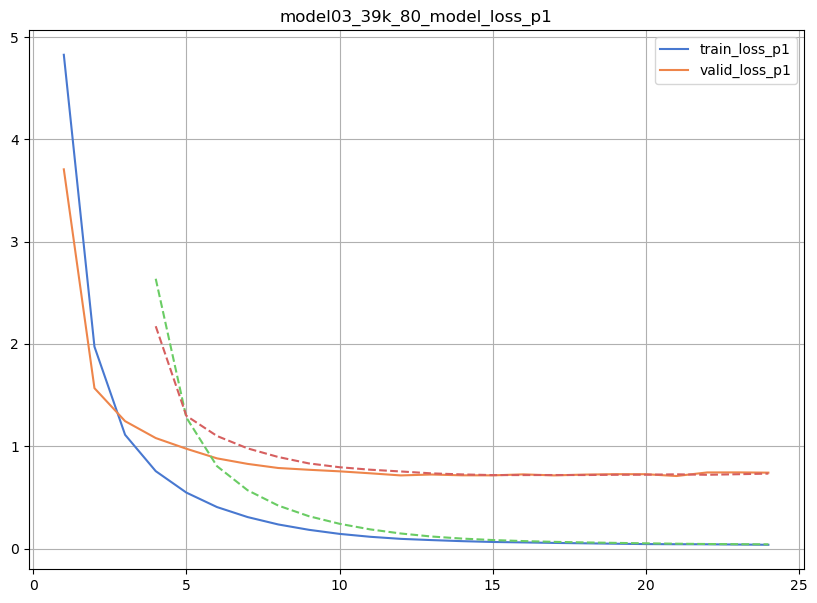

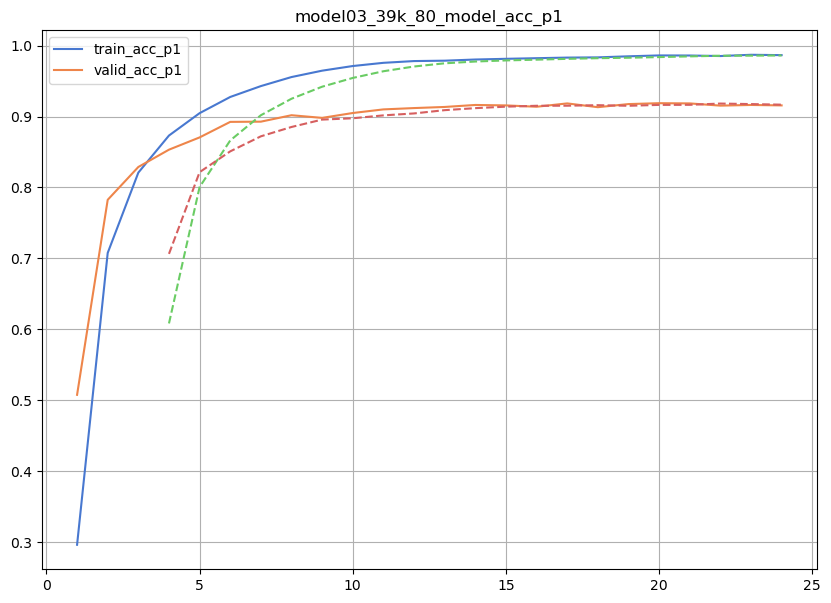

mean_train_loss_p2: 0.032287370413541794, mean_valid_loss_p2: 0.678270697593689
mean_train_acc_p2: 0.9888371403699503, mean_valid_acc_p2: 0.9092708333333334


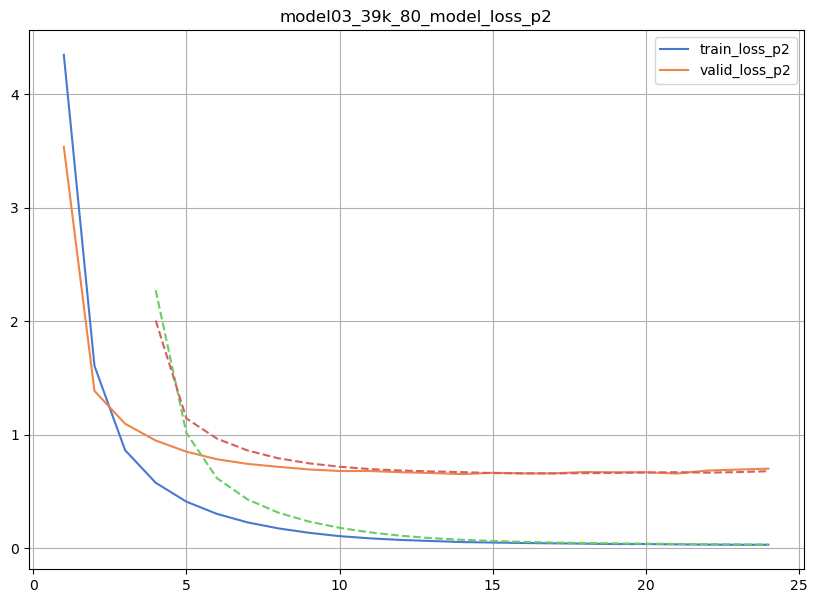

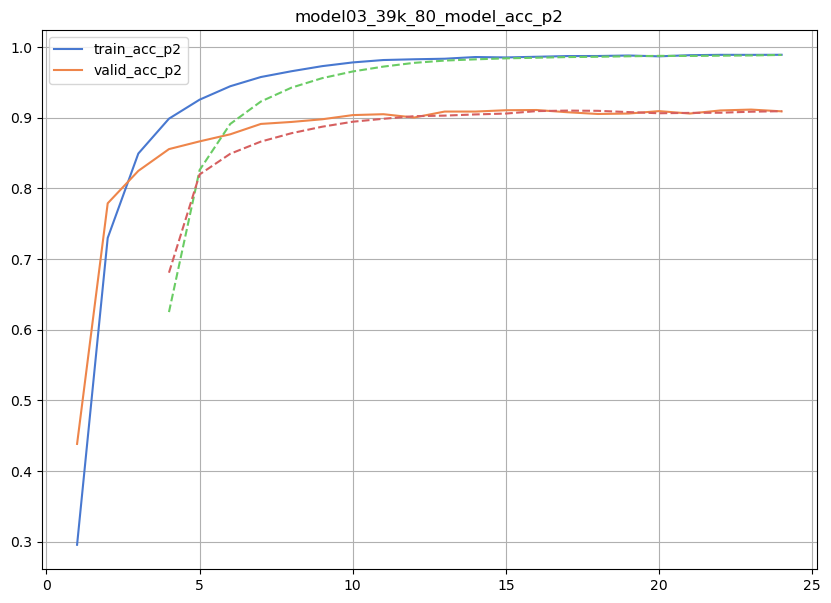

mean_train_loss_p3: 0.013445992022752762, mean_valid_loss_p3: 0.1574607491493225
mean_train_acc_p3: 0.9953423871084643, mean_valid_acc_p3: 0.9704166666666666


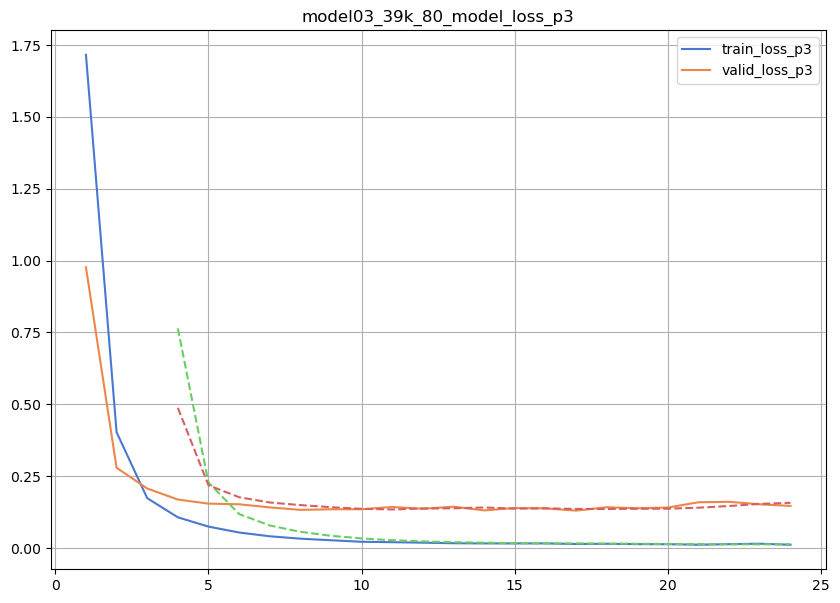

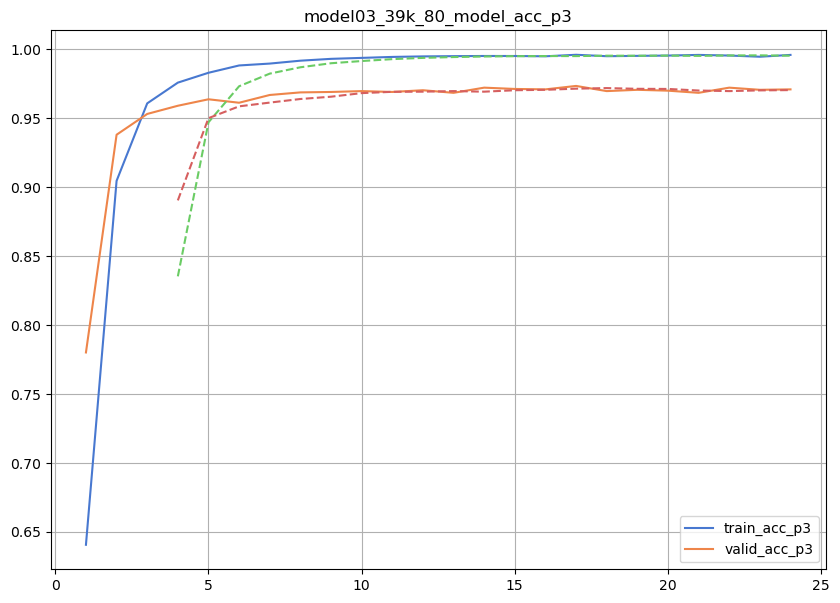

In [10]:
draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=3, modelname=f"model03_39k_{int(SEQ_IDENTITY*100)}"
)

In [9]:
path_savemodel = f"{MODEL_FOLDER}/model04_39k_{int(SEQ_IDENTITY*100)}.pth"
print("path_savemodel:", path_savemodel)

# 实例化Net类，传入蛋白语言模型和化学分子语言模型的模型和分词器
# Instantiate the Net class and pass in the model and word segmenter of protein language model and chemical molecule language model
model04 = NetESM(
    ESM2_t33_model,
    ESM2_t33_tokenizer,
    chemBERTa_MLM_model,
    chemBERTa_MLM_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
model04 = nn.DataParallel(model04, device_ids=[0, 1, 2, 3]).to(device)

# 定义一个交叉熵损失函数
# Define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# 调用训练函数，训练50个epoch
# Call the training function and train for 50 epochs
train_losses, test_losses, train_accs, test_accs = train(
    train_data, valid_data, model04, criterion, path_savemodel=path_savemodel, epochs=50, patience=10, lr=2e-5
)

path_savemodel: model/model04_39k_80.pth


[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not removing hydrogen atom without neighbors
[19:12:24] WARNING: not r

Epoch 1, train loss: tensor([5.2524, 4.7330, 1.8097], device='cuda:0')


[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not removing hydrogen atom without neighbors
[19:36:03] WARNING: not r

valid loss: tensor([4.0704, 3.7183, 1.0884], device='cuda:0')
=> Saving checkpoint


[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not removing hydrogen atom without neighbors
[19:38:15] WARNING: not r

Epoch 2, train loss: tensor([2.1683, 1.8115, 0.4525], device='cuda:0')


[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not removing hydrogen atom without neighbors
[20:01:53] WARNING: not r

valid loss: tensor([1.7412, 1.5990, 0.3294], device='cuda:0')
=> Saving checkpoint


[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not removing hydrogen atom without neighbors
[20:04:06] WARNING: not r

Epoch 3, train loss: tensor([1.2744, 1.0151, 0.2009], device='cuda:0')


[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not removing hydrogen atom without neighbors
[20:27:43] WARNING: not r

valid loss: tensor([1.4097, 1.2892, 0.2277], device='cuda:0')
=> Saving checkpoint


[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not removing hydrogen atom without neighbors
[20:29:55] WARNING: not r

Epoch 4, train loss: tensor([0.8936, 0.7026, 0.1246], device='cuda:0')


[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not removing hydrogen atom without neighbors
[20:53:34] WARNING: not r

valid loss: tensor([1.2476, 1.1341, 0.1915], device='cuda:0')
=> Saving checkpoint


[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not removing hydrogen atom without neighbors
[20:55:46] WARNING: not r

Epoch 5, train loss: tensor([0.6678, 0.5223, 0.0869], device='cuda:0')


[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not removing hydrogen atom without neighbors
[21:19:28] WARNING: not r

valid loss: tensor([1.1261, 1.0378, 0.1733], device='cuda:0')
=> Saving checkpoint


[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not removing hydrogen atom without neighbors
[21:21:40] WARNING: not r

Epoch 6, train loss: tensor([0.5139, 0.4070, 0.0648], device='cuda:0')


[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not removing hydrogen atom without neighbors
[21:45:21] WARNING: not r

valid loss: tensor([1.0617, 0.9733, 0.1651], device='cuda:0')
=> Saving checkpoint


[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not removing hydrogen atom without neighbors
[21:47:33] WARNING: not r

Epoch 7, train loss: tensor([0.4049, 0.3236, 0.0511], device='cuda:0')


[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not removing hydrogen atom without neighbors
[22:11:15] WARNING: not r

valid loss: tensor([1.0011, 0.9204, 0.1633], device='cuda:0')
=> Saving checkpoint


[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not removing hydrogen atom without neighbors
[22:13:28] WARNING: not r

Epoch 8, train loss: tensor([0.3248, 0.2642, 0.0415], device='cuda:0')


[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not removing hydrogen atom without neighbors
[22:37:08] WARNING: not r

valid loss: tensor([0.9615, 0.8920, 0.1644], device='cuda:0')
=> Saving checkpoint


[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not removing hydrogen atom without neighbors
[22:39:21] WARNING: not r

Epoch 9, train loss: tensor([0.2655, 0.2217, 0.0368], device='cuda:0')


[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not removing hydrogen atom without neighbors
[23:03:02] WARNING: not r

valid loss: tensor([0.9323, 0.8850, 0.1594], device='cuda:0')
=> Saving checkpoint


[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not removing hydrogen atom without neighbors
[23:05:15] WARNING: not r

Epoch 10, train loss: tensor([0.2188, 0.1864, 0.0300], device='cuda:0')


[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not removing hydrogen atom without neighbors
[23:28:53] WARNING: not r

valid loss: tensor([0.9231, 0.8606, 0.1609], device='cuda:0')
=> Saving checkpoint


[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not removing hydrogen atom without neighbors
[23:31:05] WARNING: not r

Epoch 11, train loss: tensor([0.1846, 0.1627, 0.0274], device='cuda:0')


[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not removing hydrogen atom without neighbors
[23:54:44] WARNING: not r

valid loss: tensor([0.8954, 0.8549, 0.1514], device='cuda:0')
=> Saving checkpoint


[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not removing hydrogen atom without neighbors
[23:56:57] WARNING: not r

Epoch 12, train loss: tensor([0.1576, 0.1422, 0.0253], device='cuda:0')


[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not removing hydrogen atom without neighbors
[00:20:35] WARNING: not r

valid loss: tensor([0.8786, 0.8307, 0.1577], device='cuda:0')
=> Saving checkpoint


[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not removing hydrogen atom without neighbors
[00:22:48] WARNING: not r

Epoch 13, train loss: tensor([0.1405, 0.1278, 0.0245], device='cuda:0')


[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not removing hydrogen atom without neighbors
[00:46:26] WARNING: not r

valid loss: tensor([0.8738, 0.8401, 0.1511], device='cuda:0')


[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not removing hydrogen atom without neighbors
[00:48:34] WARNING: not r

Epoch 14, train loss: tensor([0.1260, 0.1166, 0.0214], device='cuda:0')


[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not removing hydrogen atom without neighbors
[01:12:13] WARNING: not r

valid loss: tensor([0.8680, 0.8355, 0.1507], device='cuda:0')
=> Saving checkpoint


[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not r

Epoch 15, train loss: tensor([0.1134, 0.1067, 0.0213], device='cuda:0')


[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not removing hydrogen atom without neighbors
[01:38:04] WARNING: not r

valid loss: tensor([0.8653, 0.8417, 0.1530], device='cuda:0')


[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not removing hydrogen atom without neighbors
[01:40:12] WARNING: not r

Epoch 16, train loss: tensor([0.1050, 0.0993, 0.0197], device='cuda:0')


[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not removing hydrogen atom without neighbors
[02:03:53] WARNING: not r

valid loss: tensor([0.8472, 0.8158, 0.1535], device='cuda:0')
=> Saving checkpoint


[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not removing hydrogen atom without neighbors
[02:06:06] WARNING: not r

Epoch 17, train loss: tensor([0.0963, 0.0905, 0.0185], device='cuda:0')


[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not removing hydrogen atom without neighbors
[02:29:45] WARNING: not r

valid loss: tensor([0.8737, 0.8505, 0.1582], device='cuda:0')


[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not removing hydrogen atom without neighbors
[02:31:53] WARNING: not r

Epoch 18, train loss: tensor([0.0895, 0.0863, 0.0176], device='cuda:0')


[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not removing hydrogen atom without neighbors
[02:55:33] WARNING: not r

valid loss: tensor([0.8284, 0.8146, 0.1641], device='cuda:0')
=> Saving checkpoint


[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not removing hydrogen atom without neighbors
[02:57:46] WARNING: not r

Epoch 19, train loss: tensor([0.0840, 0.0812, 0.0176], device='cuda:0')


[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not removing hydrogen atom without neighbors
[03:21:31] WARNING: not r

valid loss: tensor([0.8482, 0.8040, 0.1470], device='cuda:0')
=> Saving checkpoint


[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not removing hydrogen atom without neighbors
[03:23:45] WARNING: not r

Epoch 20, train loss: tensor([0.0784, 0.0749, 0.0155], device='cuda:0')


[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not removing hydrogen atom without neighbors
[03:47:28] WARNING: not r

valid loss: tensor([0.8461, 0.8330, 0.1496], device='cuda:0')


[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not removing hydrogen atom without neighbors
[03:49:38] WARNING: not r

Epoch 21, train loss: tensor([0.0727, 0.0707, 0.0151], device='cuda:0')


[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not removing hydrogen atom without neighbors
[04:13:22] WARNING: not r

valid loss: tensor([0.8379, 0.8406, 0.1539], device='cuda:0')


[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not removing hydrogen atom without neighbors
[04:15:31] WARNING: not r

Epoch 22, train loss: tensor([0.0703, 0.0677, 0.0144], device='cuda:0')


[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not removing hydrogen atom without neighbors
[04:39:15] WARNING: not r

valid loss: tensor([0.8252, 0.8207, 0.1408], device='cuda:0')
=> Saving checkpoint


[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not removing hydrogen atom without neighbors
[04:41:28] WARNING: not r

Epoch 23, train loss: tensor([0.0682, 0.0657, 0.0161], device='cuda:0')


[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not removing hydrogen atom without neighbors
[05:05:08] WARNING: not r

valid loss: tensor([0.8468, 0.8339, 0.1550], device='cuda:0')


[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not removing hydrogen atom without neighbors
[05:07:17] WARNING: not r

Epoch 24, train loss: tensor([0.0629, 0.0608, 0.0140], device='cuda:0')


[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not removing hydrogen atom without neighbors
[05:30:59] WARNING: not r

valid loss: tensor([0.8461, 0.8264, 0.1494], device='cuda:0')


[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not removing hydrogen atom without neighbors
[05:33:08] WARNING: not r

Epoch 25, train loss: tensor([0.0601, 0.0572, 0.0134], device='cuda:0')


[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not removing hydrogen atom without neighbors
[05:56:51] WARNING: not r

valid loss: tensor([0.8344, 0.8280, 0.1541], device='cuda:0')


[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not removing hydrogen atom without neighbors
[05:59:01] WARNING: not r

Epoch 26, train loss: tensor([0.0573, 0.0577, 0.0121], device='cuda:0')


[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not removing hydrogen atom without neighbors
[06:22:43] WARNING: not r

valid loss: tensor([0.8267, 0.8171, 0.1503], device='cuda:0')


[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not removing hydrogen atom without neighbors
[06:24:53] WARNING: not r

Epoch 27, train loss: tensor([0.0546, 0.0548, 0.0122], device='cuda:0')


[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not removing hydrogen atom without neighbors
[06:48:36] WARNING: not r

valid loss: tensor([0.8429, 0.8504, 0.1549], device='cuda:0')


[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not removing hydrogen atom without neighbors
[06:50:45] WARNING: not r

Epoch 28, train loss: tensor([0.0537, 0.0511, 0.0124], device='cuda:0')


[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not removing hydrogen atom without neighbors
[07:14:29] WARNING: not r

valid loss: tensor([0.8581, 0.8453, 0.1623], device='cuda:0')


[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not removing hydrogen atom without neighbors
[07:16:38] WARNING: not r

Epoch 29, train loss: tensor([0.0521, 0.0502, 0.0132], device='cuda:0')


[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not removing hydrogen atom without neighbors
[07:40:21] WARNING: not r

valid loss: tensor([0.8638, 0.8514, 0.1617], device='cuda:0')


[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not removing hydrogen atom without neighbors
[07:42:31] WARNING: not r

Epoch 30, train loss: tensor([0.0496, 0.0501, 0.0115], device='cuda:0')


[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not removing hydrogen atom without neighbors
[08:06:13] WARNING: not r

valid loss: tensor([0.8529, 0.8447, 0.1625], device='cuda:0')


[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not removing hydrogen atom without neighbors
[08:08:23] WARNING: not r

Epoch 31, train loss: tensor([0.0488, 0.0454, 0.0108], device='cuda:0')


[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not removing hydrogen atom without neighbors
[08:32:01] WARNING: not r

valid loss: tensor([0.8575, 0.8636, 0.1723], device='cuda:0')


[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not removing hydrogen atom without neighbors
[08:34:10] WARNING: not r

Epoch 32, train loss: tensor([0.0458, 0.0436, 0.0116], device='cuda:0')


[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not removing hydrogen atom without neighbors
[08:57:52] WARNING: not r

valid loss: tensor([0.8490, 0.8356, 0.1453], device='cuda:0')
early stop at epoch 32
=> Training completed! Best loss at epoch 22


mean_train_loss_p1: 0.050170011818408966, mean_valid_loss_p1: 0.8580412268638611
mean_train_acc_p1: 0.9812048492941325, mean_valid_acc_p1: 0.9009583333333335


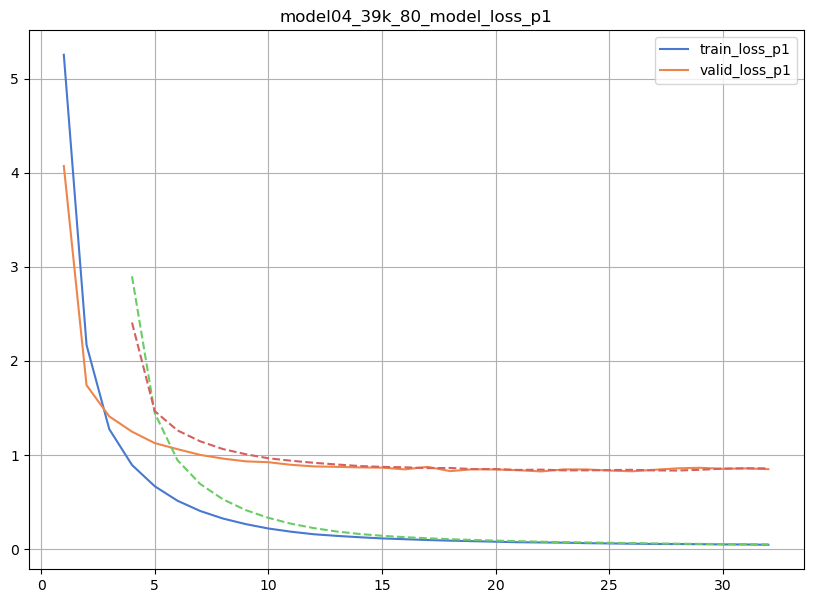

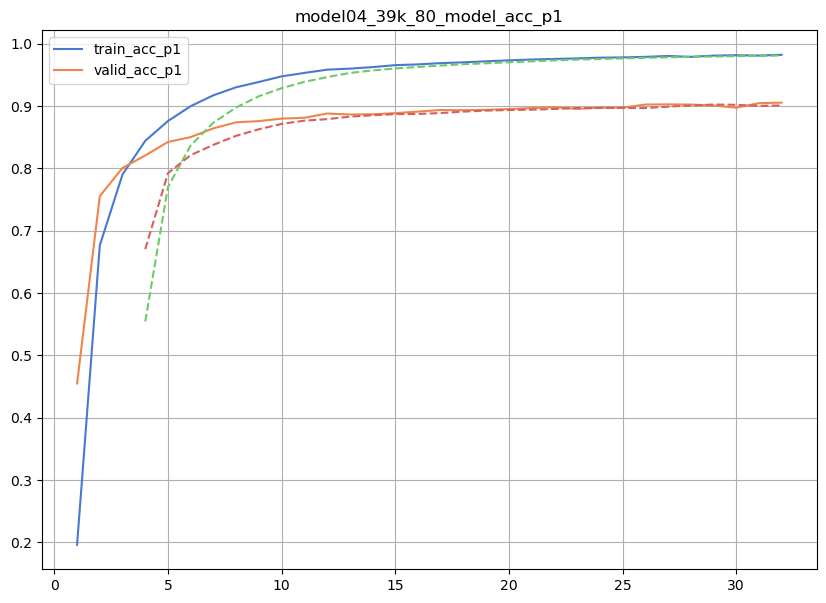

mean_train_loss_p2: 0.04854303225874901, mean_valid_loss_p2: 0.8532531261444092
mean_train_acc_p2: 0.9810357187874206, mean_valid_acc_p2: 0.8822638888888888


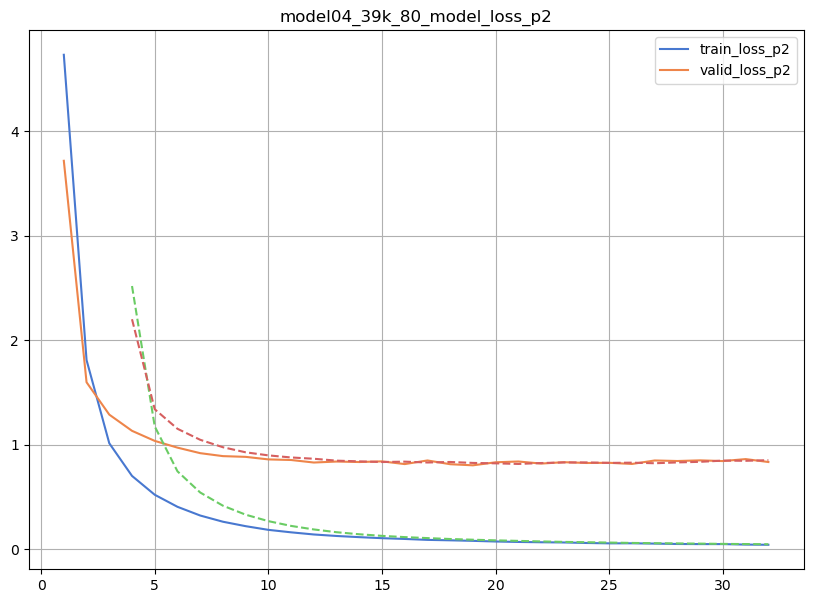

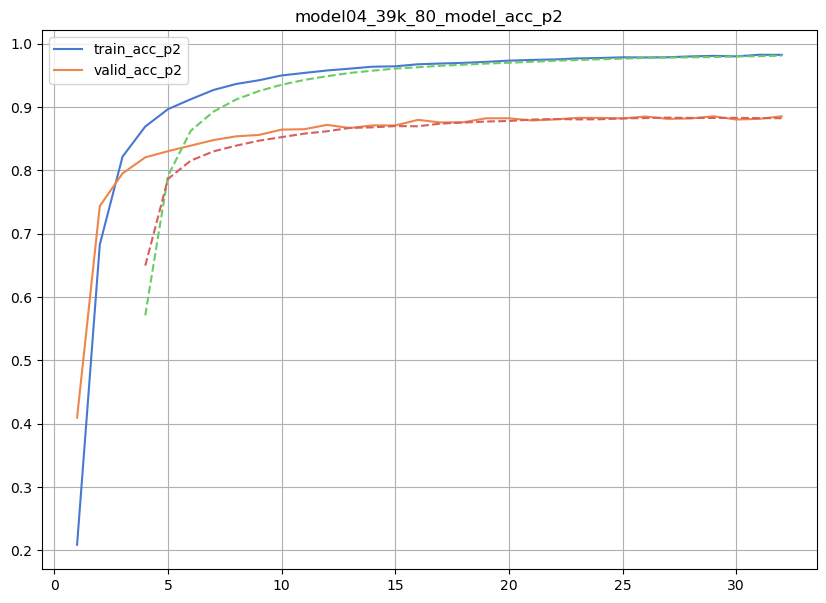

mean_train_loss_p3: 0.011836002580821514, mean_valid_loss_p3: 0.16548888385295868
mean_train_acc_p3: 0.9951939363143631, mean_valid_acc_p3: 0.9654166666666667


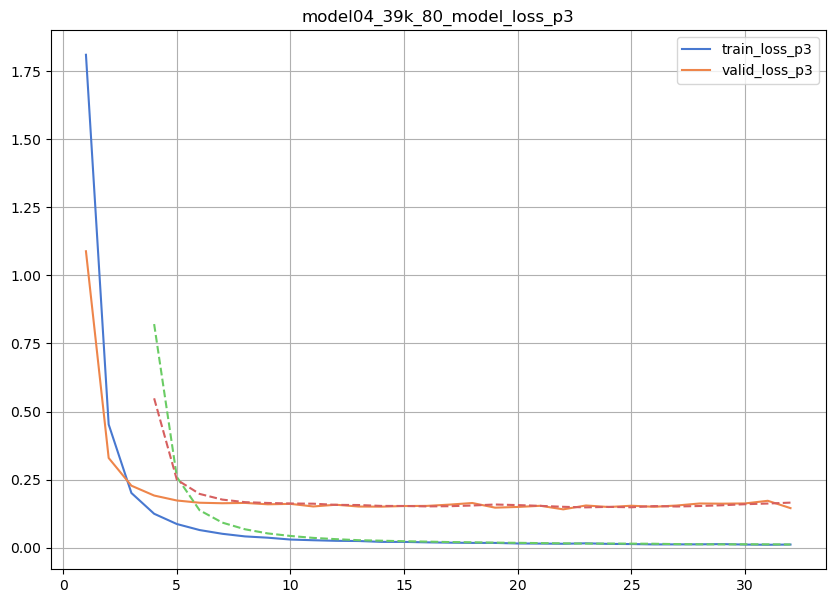

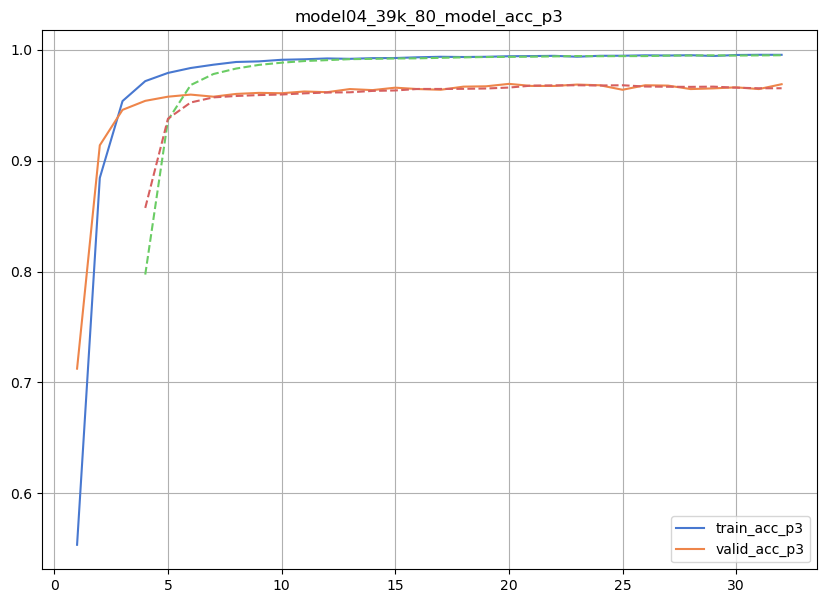

In [10]:
draw_loss_acc(
    train_losses, test_losses, train_accs, test_accs, step=3, modelname=f"model04_39k_{int(SEQ_IDENTITY*100)}"
)